In [1]:
import torch

if torch.cuda.is_available():
    print("CUDA is available! ✅")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is NOT available ❌")

CUDA is available! ✅
Number of GPUs: 1
Current GPU: NVIDIA GeForce RTX 4050 Laptop GPU


In [2]:
!pip install rasterio geopandas shapely scikit-learn matplotlib seaborn imageio opencv-python
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install albumentations tqdm segmentation-models-pytorch



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://download.pytorch.org/whl/cu121



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import torch
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Mapping
import geopandas as gpd
import folium
from folium.plugins import HeatMap

# Raster & Remote Sensing
import rasterio
import rasterio.plot
from rasterio.mask import mask

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Geospatial tools
import shapely
from shapely.geometry import box
import os
import json


In [44]:
import os
import zipfile
import requests

# Define download URL and paths
url = "https://github.com/datameet/maps/archive/refs/heads/master.zip"
zip_path = "datameet_maps.zip"
extract_dir = "datameet_maps"

# Download the zip file
response = requests.get(url)
with open(zip_path, "wb") as f:
    f.write(response.content)

# Unzip it
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Downloaded and extracted India district shapefiles.")


✅ Downloaded and extracted India district shapefiles.


In [5]:
import os

# Walk through the whole repo and print all .shp files
for root, dirs, files in os.walk("datameet_maps/maps-master"):
    for file in files:
        if file.endswith(".shp"):
            print(os.path.join(root, file))


datameet_maps/maps-master\assembly-constituencies\India_AC.shp
datameet_maps/maps-master\Districts\Census_2001\2001_Dist.shp
datameet_maps/maps-master\Districts\Census_2011\2011_Dist.shp
datameet_maps/maps-master\eci\AC_Data\States\S01\S01_AC.shp
datameet_maps/maps-master\eci\AC_Data\States\S02\S02_AC.shp
datameet_maps/maps-master\eci\AC_Data\States\S03\S03_AC.shp
datameet_maps/maps-master\eci\AC_Data\States\S04\S04_AC.shp
datameet_maps/maps-master\eci\AC_Data\States\S05\S05_AC.shp
datameet_maps/maps-master\eci\AC_Data\States\S06\S06_AC.shp
datameet_maps/maps-master\eci\AC_Data\States\S07\S07_AC.shp
datameet_maps/maps-master\eci\AC_Data\States\S08\S08_AC.shp
datameet_maps/maps-master\eci\AC_Data\States\S09\S09_AC.shp
datameet_maps/maps-master\eci\AC_Data\States\S10\S10_AC.shp
datameet_maps/maps-master\eci\AC_Data\States\S11\S11_AC.shp
datameet_maps/maps-master\eci\AC_Data\States\S12\S12_AC.shp
datameet_maps/maps-master\eci\AC_Data\States\S13\S13_AC.shp
datameet_maps/maps-master\eci\AC_

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Use forward slashes in path (even on Windows)
shp_path = "datameet_maps/maps-master/Districts/Census_2011/2011_Dist.shp"

# Load the shapefile
districts = gpd.read_file(shp_path)

# Preview the dataframe
print(districts.head())

# Check available columns
print(districts.columns)


     DISTRICT           ST_NM  ST_CEN_CD  DT_CEN_CD  censuscode  \
0    Adilabad  Andhra Pradesh         28          1         532   
1        Agra   Uttar Pradesh          9         15         146   
2   Ahmadabad         Gujarat         24          7         474   
3  Ahmadnagar     Maharashtra         27         26         522   
4      Aizawl         Mizoram         15          3         283   

                                            geometry  
0  POLYGON ((78.84972 19.7601, 78.85102 19.75945,...  
1  POLYGON ((78.19803 27.4028, 78.19804 27.40278,...  
2  MULTIPOLYGON (((72.03456 23.50527, 72.03337 23...  
3  POLYGON ((74.67333 19.9467, 74.67393 19.93509,...  
4  POLYGON ((92.98749 24.40453, 92.99107 24.40236...  
Index(['DISTRICT', 'ST_NM', 'ST_CEN_CD', 'DT_CEN_CD', 'censuscode',
       'geometry'],
      dtype='object')


In [31]:
# Filter rows where state name is Madhya Pradesh
Uttarakhand_districts = districts[districts["ST_NM"] == "Uttarakhand"]

# Sanity check — how many districts?
print(f"Number of Uttarakhand districts: {len(Uttarakhand_districts)}")
print(Uttarakhand_districts["DISTRICT"].unique())  # See district names


Number of Uttarakhand districts: 13
['Almora' 'Bageshwar' 'Chamoli' 'Champawat' 'Dehradun' 'Garhwal' 'Hardwar'
 'Nainital' 'Pithoragarh' 'Rudraprayag' 'Tehri Garhwal'
 'Udham Singh Nagar' 'Uttarkashi']


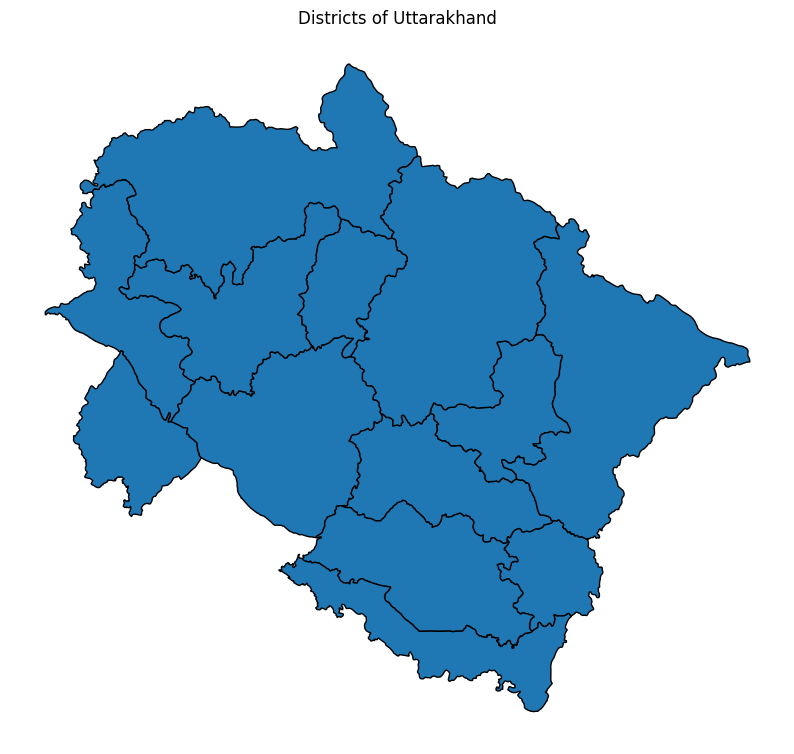

In [32]:
# Plotting MP district map
Uttarakhand_districts.plot(edgecolor='black', figsize=(10, 10))
plt.title("Districts of Uttarakhand")
plt.axis("off")
plt.show()


In [18]:
import pandas as pd

# Load the FIRMS CSV
fire_df = pd.read_csv("firearchive.csv")

# Preview it
fire_df.head()


latitude  longitude  brightness  scan  track    acq_date  acq_time  \
0  25.34799   91.58890      330.03  0.75   0.77  2019-01-01       601   
1  25.34379   91.59160      329.90  0.75   0.77  2019-01-01       601   
2  27.51303   93.72855      331.15  0.50   0.66  2019-01-01       601   
3  26.70929   91.04409      327.76  0.74   0.76  2019-01-01       601   
4  26.68514   91.01135      333.99  0.75   0.77  2019-01-01       601   

  satellite instrument confidence  version  bright_t31   frp daynight  type  
0         N      VIIRS          n        2      289.92  6.23        D     0  
1         N      VIIRS          n        2      291.39  5.63        D     0  
2         N      VIIRS          n        2      289.08  3.16        D     0  
3         N      VIIRS          n        2      292.75  7.93        D     0  
4         N      VIIRS          n        2      294.75  8.02        D     0

c:\Users\suyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


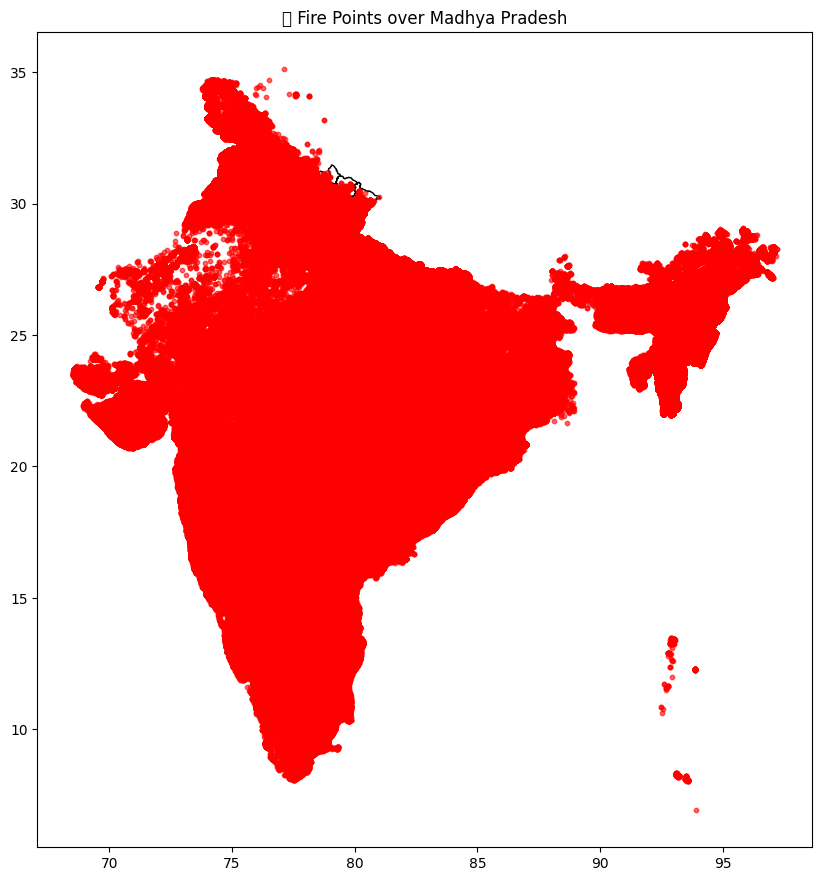

In [19]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Convert fire_df to GeoDataFrame
geometry = [Point(xy) for xy in zip(fire_df['longitude'], fire_df['latitude'])]
fire_gdf = gpd.GeoDataFrame(fire_df, geometry=geometry, crs="EPSG:4326")

# Load Indian districts shapefile
districts = gpd.read_file("datameet_maps/maps-master/Districts/Census_2011/2011_Dist.shp")

# Filter only Uttarakhand
Uttarakhand_districts = districts[districts['ST_NM'].str.lower() == 'uttarakhand']


# Plot
fig, ax = plt.subplots(figsize=(10, 12))
Uttarakhand_districts.plot(ax=ax, color='white', edgecolor='black')
fire_gdf.plot(ax=ax, color='red', markersize=10, alpha=0.6)
plt.title("🔥 Fire Points over Madhya Pradesh")
plt.show()


c:\Users\suyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


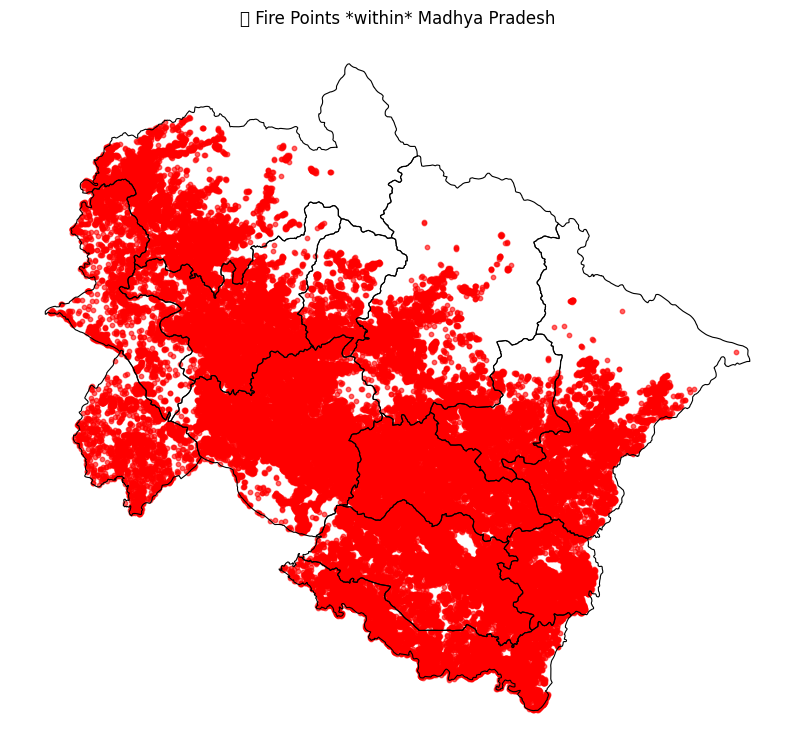

In [20]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Convert fire_df to GeoDataFrame
geometry = [Point(xy) for xy in zip(fire_df['longitude'], fire_df['latitude'])]
fire_gdf = gpd.GeoDataFrame(fire_df, geometry=geometry, crs="EPSG:4326")

# Load Indian districts shapefile
districts = gpd.read_file("datameet_maps/maps-master/Districts/Census_2011/2011_Dist.shp")

# Filter only Uttarakhand
Uttrakhand_districts = districts[districts['ST_NM'].str.lower() == 'uttarakhand']

# 🔥 Clip fire points to only those inside Uttarakhand
fires_in_uttarakhand = gpd.clip(fire_gdf, Uttrakhand_districts)

# Plot
fig, ax = plt.subplots(figsize=(10, 12))
Uttarakhand_districts.boundary.plot(ax=ax, color='black', linewidth=0.8)
fires_in_uttarakhand.plot(ax=ax, color='red', markersize=10, alpha=0.6)
plt.title("🔥 Fire Points *within* Madhya Pradesh")
plt.axis("off")
plt.show()


In [21]:
# Spatial join: attach each fire point to its district
fires_with_district = gpd.sjoin(fires_in_uttarakhand, Uttarakhand_districts, how="inner", predicate="within")

# Count fires per district
fire_counts = fires_with_district['DISTRICT'].value_counts().reset_index()
fire_counts.columns = ['District', 'Fire_Count']
print(fire_counts)


             District  Fire_Count
0             Garhwal       14368
1            Nainital       12263
2              Almora       10968
3       Tehri Garhwal        9363
4   Udham Singh Nagar        7751
5          Uttarkashi        6604
6           Champawat        5949
7         Pithoragarh        5499
8             Chamoli        5093
9           Bageshwar        3881
10           Dehradun        2577
11            Hardwar        2003
12        Rudraprayag        1696


c:\Users\suyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


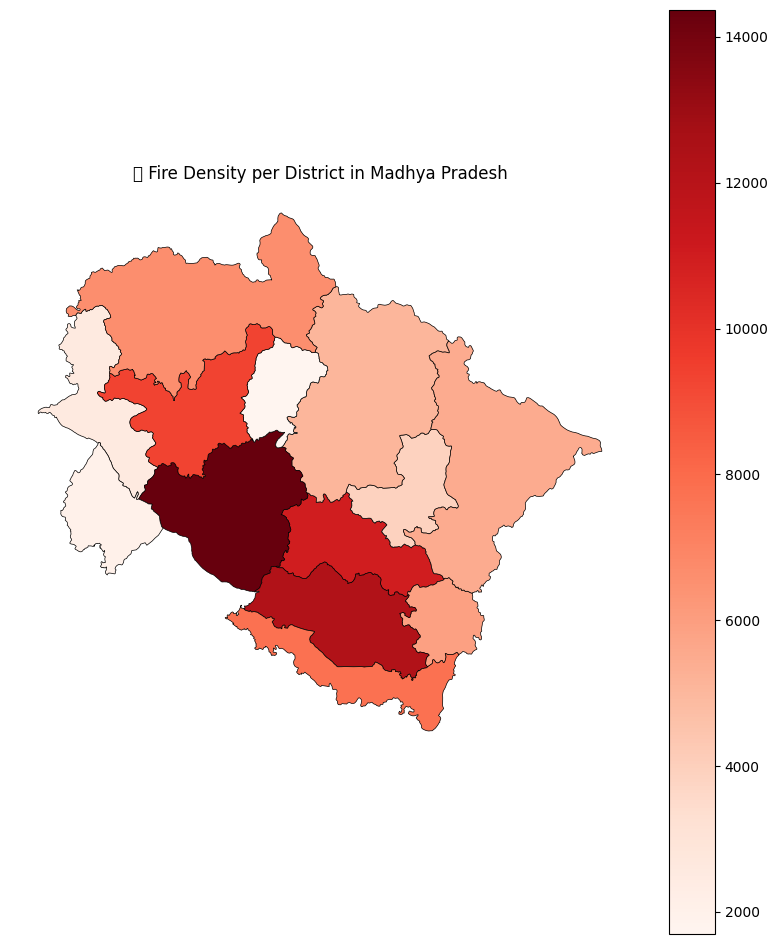

In [23]:
# Merge fire counts with district geometries
Uttarakhand_districts_fire = Uttarakhand_districts.merge(fire_counts, left_on='DISTRICT', right_on='District', how='left')
Uttarakhand_districts_fire['Fire_Count'] = Uttarakhand_districts_fire['Fire_Count'].fillna(0)

# Plot
fig, ax = plt.subplots(figsize=(10, 12))
Uttarakhand_districts_fire.plot(column='Fire_Count', ax=ax, legend=True,
                       cmap='Reds', edgecolor='black', linewidth=0.5)
plt.title("🔥 Fire Density per District in Madhya Pradesh")
plt.axis("off")
plt.show()


c:\Users\suyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


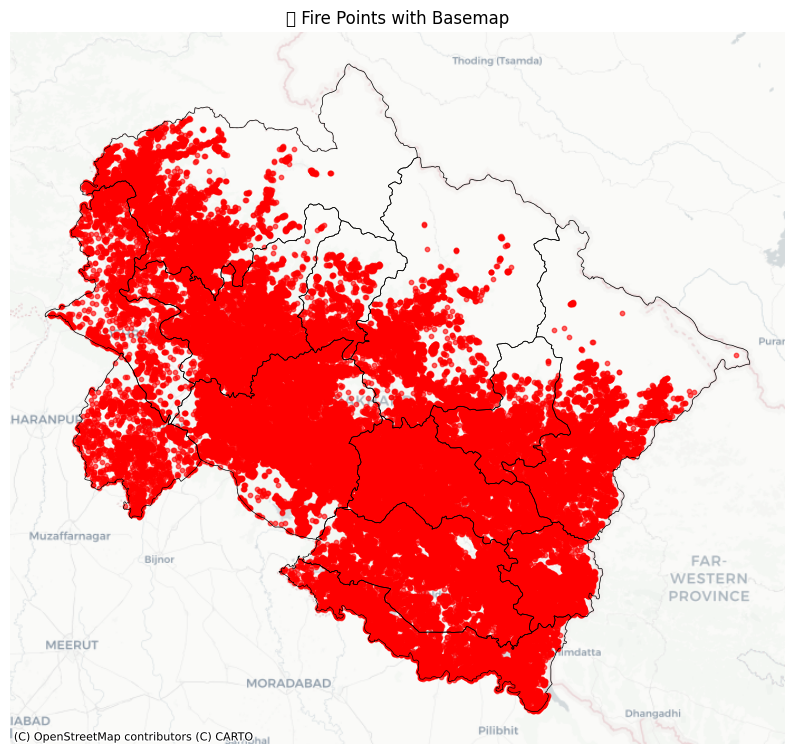

In [24]:
import contextily as ctx

fig, ax = plt.subplots(figsize=(10, 12))
fires_in_uttarakhand.to_crs(epsg=3857).plot(ax=ax, color='red', markersize=10, alpha=0.6)
Uttarakhand_districts.to_crs(epsg=3857).boundary.plot(ax=ax, color='black', linewidth=0.5)

# ✅ Fixed basemap source
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

plt.title("🔥 Fire Points with Basemap")
plt.axis("off")
plt.show()


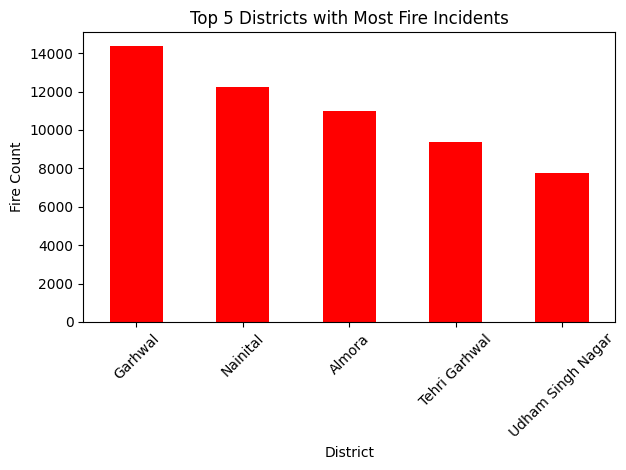

In [25]:
# Sort & plot
fire_counts.sort_values(by="Fire_Count", ascending=False).head(5).plot(
    x='District', y='Fire_Count', kind='bar', color='red', legend=False)

plt.title("Top 5 Districts with Most Fire Incidents")
plt.xlabel("District")
plt.ylabel("Fire Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [50]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin
import numpy as np
import os
from tqdm import tqdm

# Load CSV
df = pd.read_csv('firearchive.csv')

# ---- Filter to Uttarakhand BBox (approx bounding box) ----
uk_min_lat, uk_max_lat = 28.0, 31.5
uk_min_lon, uk_max_lon = 77.5, 81.5

df = df[(df['latitude'] >= uk_min_lat) & (df['latitude'] <= uk_max_lat) &
        (df['longitude'] >= uk_min_lon) & (df['longitude'] <= uk_max_lon)]

# ---- Confidence Filter ----
# Keep only high-confidence fires or brightness > 330
df = df[(df['confidence'] == 'h') | (df['brightness'] > 330)]

# ---- Convert to GeoDataFrame ----
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)
gdf.crs = "EPSG:4326"

# ---- Define raster properties ----
pixel_size = 0.0027  # roughly 300m per pixel (adjust for Sentinel later)
minx, miny, maxx, maxy = gdf.total_bounds
width = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)
transform = from_origin(minx, maxy, pixel_size, pixel_size)

# ---- Group by date and rasterize ----
os.makedirs("fire_rasters", exist_ok=True)

for date, group in tqdm(gdf.groupby('acq_date'), desc="Rasterizing fires"):
    shapes = ((pt, 1) for pt in group.geometry)

    raster = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='uint8'
    )

    output_path = f"fire_rasters/fire_{date}.tif"

    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype='uint8',
        crs='EPSG:4326',
        transform=transform
    ) as dst:
        dst.write(raster, 1)


Rasterizing fires: 100%|██████████| 1531/1531 [00:19<00:00, 78.62it/s]


In [12]:
import os
import rasterio
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from tqdm import tqdm

# Inputs
fire_folder = "fire_rasters/"  # folder with daily fire rasters
uttarakhand_shp = "datameet_maps/maps-master/Districts/Census_2011/2011_Dist.shp"  # full Indian districts
out_file = "fire_positive_samples_clipped.csv"

# Load Uttarakhand boundary
districts = gpd.read_file(uttarakhand_shp)
uttarakhand = districts[districts['ST_NM'].str.lower() == 'uttarakhand']
uttarakhand = uttarakhand.to_crs("EPSG:4326")  # match lat/lon CRS

all_samples = []

print("Extracting fire pixels only within Uttarakhand...")

for file in tqdm(sorted(os.listdir(fire_folder))):
    if not file.endswith(".tif"):
        continue

    date_str = file.split('.')[0]  # assumes filenames like 2022-05-01.tif
    path = os.path.join(fire_folder, file)

    with rasterio.open(path) as src:
        band = src.read(1)
        rows, cols = (band > 0).nonzero()  # fire pixels only

        for row, col in zip(rows, cols):
            lon, lat = src.xy(row, col)
            pt = Point(lon, lat)

            # keep only if inside Uttarakhand
            if uttarakhand.contains(pt).any():
                all_samples.append([lat, lon, date_str, 1])  # label = 1

# Save final fire samples
df_fire = pd.DataFrame(all_samples, columns=["lat", "lon", "date", "label"])
df_fire.to_csv(out_file, index=False)
print(f"✅ Saved {len(df_fire)} fire samples inside Uttarakhand to {out_file}")


Extracting fire pixels only within Uttarakhand...


100%|██████████| 1531/1531 [00:23<00:00, 65.79it/s]


✅ Saved 41829 fire samples inside Uttarakhand to fire_positive_samples_clipped.csv


In [23]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Load fire samples
fire_df = pd.read_csv("fire_positive_samples.csv")

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(fire_df['lon'], fire_df['lat'])]
fire_gdf = gpd.GeoDataFrame(fire_df, geometry=geometry, crs="EPSG:4326")

# Load Uttarakhand shapefile
india_districts = gpd.read_file("datameet_maps/maps-master/Districts/Census_2011/2011_Dist.shp")
uttarakhand = india_districts[india_districts['ST_NM'].str.lower() == 'uttarakhand']

# Clip fire points to Uttarakhand only
fire_gdf_clipped = gpd.clip(fire_gdf, uttarakhand)

# Save final verified Uttarakhand fire points
fire_gdf_clipped.drop(columns="geometry").to_csv("fire_positive_samples_uttarakhand_only.csv", index=False)

print(f"✅ Verified and saved {len(fire_gdf_clipped)} fire points inside Uttarakhand.")


✅ Verified and saved 41829 fire points inside Uttarakhand.


c:\Users\suyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


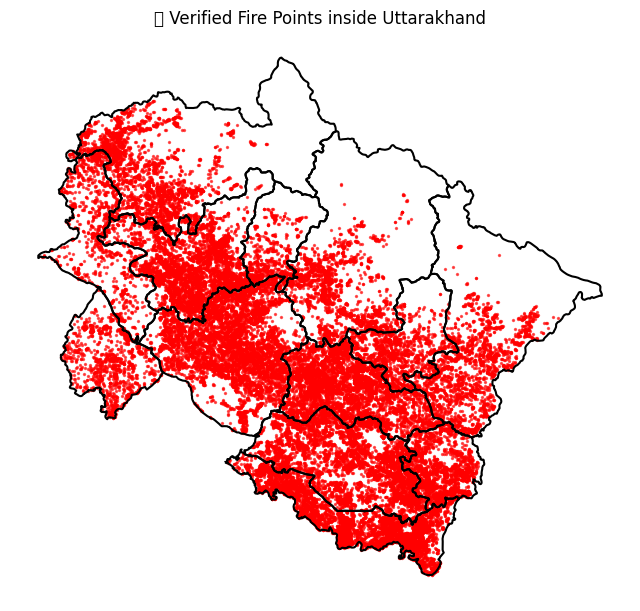

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 10))
uttarakhand.boundary.plot(ax=ax, color='black')
fire_gdf_clipped.plot(ax=ax, color='red', markersize=2, alpha=0.6)
plt.title("✅ Verified Fire Points inside Uttarakhand")
plt.axis("off")
plt.show()


In [18]:
import random
import os
import rasterio
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from tqdm import tqdm
from datetime import datetime

# Load Uttarakhand boundary
districts = gpd.read_file("datameet_maps/maps-master/Districts/Census_2011/2011_Dist.shp")
uttarakhand_gdf = districts[districts['ST_NM'].str.lower() == 'uttarakhand'].to_crs("EPSG:4326")

# Parameters
fire_folder = "fire_rasters/"
out_file = "fire_negative_samples.csv"
n_samples = 41829
samples = []

# Get raster dates
tif_files = sorted([f for f in os.listdir(fire_folder) if f.endswith('.tif')])
random.shuffle(tif_files)  # for randomness
print(f"Found {len(tif_files)} raster files.")

# Setup progress bar
pbar = tqdm(total=n_samples, desc="Sampling non-fire points")

# Sampling loop
for tif_file in tif_files:
    if len(samples) >= n_samples:
        break

    date_str = tif_file.split('.')[0]
    tif_path = os.path.join(fire_folder, tif_file)

    try:
        with rasterio.open(tif_path) as src:
            bounds = src.bounds
            for _ in range(100):  # try 100 random points per raster
                if len(samples) >= n_samples:
                    break

                lon = random.uniform(bounds.left, bounds.right)
                lat = random.uniform(bounds.bottom, bounds.top)
                pt = Point(lon, lat)

                # Must be inside Uttarakhand polygon
                if not uttarakhand_gdf.contains(pt).any():
                    continue

                try:
                    row, col = src.index(lon, lat)
                    value = src.read(1)[row, col]
                    if value == 0:
                        samples.append([lat, lon, date_str, 0])
                        pbar.update(1)
                except:
                    continue
    except:
        continue

pbar.close()

# Save
df = pd.DataFrame(samples, columns=["lat", "lon", "date", "label"])
df.to_csv(out_file, index=False)
print(f"✅ Saved {len(df)} non-fire samples to {out_file}")


Found 1531 raster files.


Sampling non-fire points: 100%|██████████| 41829/41829 [00:41<00:00, 1003.54it/s]


✅ Saved 41829 non-fire samples to fire_negative_samples.csv


In [25]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Load fire samples
fire_df = pd.read_csv("fire_negative_samples.csv")

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(fire_df['lon'], fire_df['lat'])]
no_fire_gdf = gpd.GeoDataFrame(fire_df, geometry=geometry, crs="EPSG:4326")

# Load Uttarakhand shapefile
india_districts = gpd.read_file("datameet_maps/maps-master/Districts/Census_2011/2011_Dist.shp")
uttarakhand = india_districts[india_districts['ST_NM'].str.lower() == 'uttarakhand']

# Clip fire points to Uttarakhand only
no_fire_gdf_clipped = gpd.clip(no_fire_gdf, uttarakhand)

# # Save final verified Uttarakhand fire points
# fire_gdf_clipped.drop(columns="geometry").to_csv("fire_positive_samples_uttarakhand_only.csv", index=False)

print(f"✅ Verified {len(no_fire_gdf_clipped)} non-fire points inside Uttarakhand.")


✅ Verified 41829 non-fire points inside Uttarakhand.


c:\Users\suyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


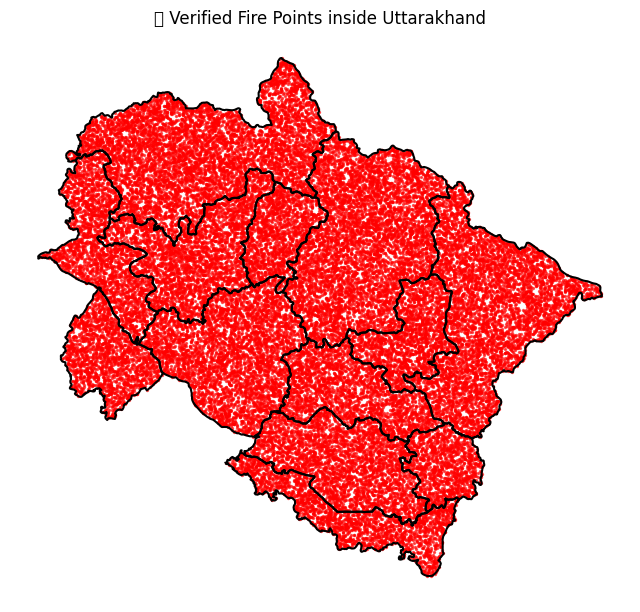

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 10))
uttarakhand.boundary.plot(ax=ax, color='black')
no_fire_gdf_clipped.plot(ax=ax, color='red', markersize=2, alpha=0.6)
plt.title("✅ Verified Fire Points inside Uttarakhand")
plt.axis("off")
plt.show()


In [2]:
import pandas as pd

df_pos = pd.read_csv("fire_positive_samples.csv")   # has label=1
df_neg = pd.read_csv("fire_negative_samples.csv")   # has label=0

df_all = pd.concat([df_pos, df_neg], ignore_index=True)
df_all.to_csv("fire_all_samples.csv", index=False)
print(df_all.head())


        lat       lon             date  label
0  30.74994  77.74983  fire_2019-01-01      1
1  30.38544  79.46163  fire_2019-01-01      1
2  30.10734  80.60373  fire_2019-01-01      1
3  30.10464  80.60913  fire_2019-01-01      1
4  30.09384  80.38233  fire_2019-01-01      1


In [3]:
import rasterio
from rasterio.merge import merge
from glob import glob
import os

# Path to folder with 20 .tif files
tif_dir = "tiffiles"
tif_files = glob(os.path.join(tif_dir, "*.tif"))

# Open all raster files
src_files_to_mosaic = [rasterio.open(f) for f in tif_files]

# Merge them
mosaic, out_trans = merge(src_files_to_mosaic)

# Copy metadata from one tile
out_meta = src_files_to_mosaic[0].meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
})

# Save merged raster
with rasterio.open("merged_uttarakhand.tif", "w", **out_meta) as dest:
    dest.write(mosaic)

print("✅ Done! Mosaic saved as 'merged_uttarakhand.tif'")


✅ Done! Mosaic saved as 'merged_uttarakhand.tif'


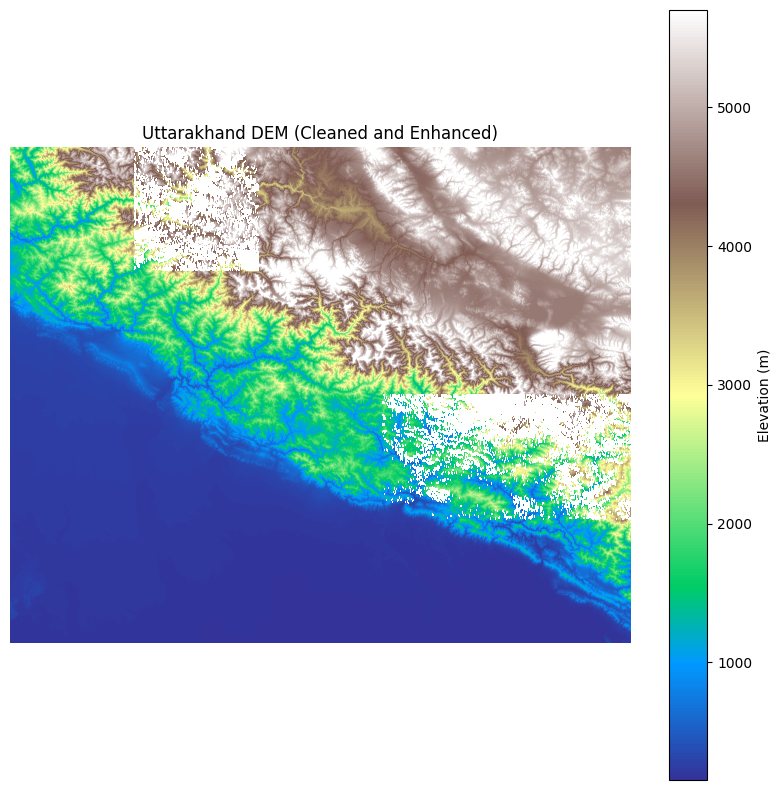

In [8]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Load the DEM
with rasterio.open("merged_uttarakhand.tif") as src:
    elevation = src.read(1)
    nodata = src.nodata if src.nodata is not None else -32767

# Mask out no-data values
elevation = np.where(elevation == nodata, np.nan, elevation)

# Stretch contrast using percentiles
vmin, vmax = np.nanpercentile(elevation, (2, 98))

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(elevation, cmap='terrain', vmin=vmin, vmax=vmax)
plt.title("Uttarakhand DEM (Cleaned and Enhanced)")
plt.colorbar(label='Elevation (m)')
plt.axis('off')
plt.show()


In [10]:
print("Shape:", elevation.shape)


Shape: (14401, 18001)


In [11]:
with rasterio.open("merged_uttarakhand.tif") as src:
    print("CRS:", src.crs)


CRS: EPSG:4326


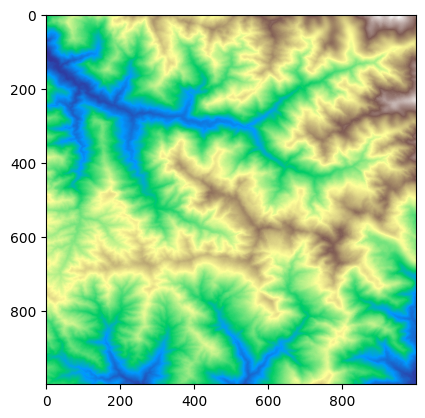

In [12]:
plt.imshow(elevation[1000:2000, 1000:2000], cmap='terrain')


(array([4.1700000e+02, 4.1493190e+06, 1.6696267e+07, 2.6143908e+07,
        1.9946334e+07, 1.1051716e+07, 5.1097880e+06, 2.2683620e+06,
        1.2317610e+06, 8.6123200e+05, 8.5403800e+05, 8.8286400e+05,
        9.3632000e+05, 8.8087200e+05, 8.6949800e+05, 8.4396400e+05,
        8.7934000e+05, 8.7076700e+05, 8.8972700e+05, 7.9566000e+05,
        7.5377900e+05, 7.2595100e+05, 7.2122800e+05, 7.2534700e+05,
        7.6336300e+05, 7.4998100e+05, 7.8780000e+05, 8.2254000e+05,
        8.6020300e+05, 8.9356900e+05, 9.5387000e+05, 9.5562400e+05,
        9.8664200e+05, 1.0205060e+06, 1.0517770e+06, 1.0824610e+06,
        1.1451130e+06, 1.1379360e+06, 1.1655150e+06, 1.1911010e+06,
        1.2161660e+06, 1.2443090e+06, 1.3028350e+06, 1.2728420e+06,
        1.2790320e+06, 1.2797120e+06, 1.2799230e+06, 1.2772980e+06,
        1.3179740e+06, 1.2616830e+06, 1.2528500e+06, 1.2372440e+06,
        1.2181910e+06, 1.1999190e+06, 1.2208070e+06, 1.1652940e+06,
        1.1399630e+06, 1.1106020e+06, 1.0764100e

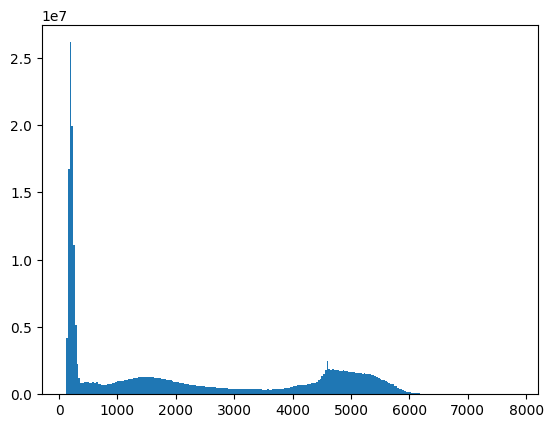

In [13]:
plt.hist(elevation[~np.isnan(elevation)].flatten(), bins=256)


In [2]:
import pandas as pd
import rasterio

# Load your dataset
df = pd.read_csv(r"C:\Users\suyas\Hackorbit\dataset\fire_all_samples.csv")

# Open the DEM raster
with rasterio.open("merged_uttarakhand.tif") as dem:
    # Prepare list of (lon, lat) tuples
    coords = list(zip(df['lon'], df['lat']))
    
    # Sample all at once
    elevations = list(dem.sample(coords))
    
    # Flatten and assign to new column
    df['elevation'] = [val[0] if val[0] != dem.nodata else None for val in elevations]

# Save the updated dataset
df.to_csv("fire_all_samples_with_elevation.csv", index=False)
print("✅ Done! Elevation added.")


✅ Done! Elevation added.


In [40]:
import pandas as pd

# Load the CSV
df = pd.read_csv(r"C:\Users\suyas\Hackorbit\fire_all_samples_with_elevation.csv")

# Check for full duplicate rows
duplicate_rows = df[df.duplicated()]
print(f"🔍 Found {len(duplicate_rows)} fully duplicate rows")

# Optional: Save duplicates to inspect
# duplicate_rows.to_csv("duplicates_full.csv", index=False)


🔍 Found 0 fully duplicate rows


In [43]:
coord_duplicates = df[df.duplicated(subset=['lat', 'lon', 'date'])]
print(f"📍 Found {len(coord_duplicates)} rows with same (lat, lon, date)")

# coord_duplicates.to_csv("duplicates_by_coord_date.csv", index=False)


📍 Found 0 rows with same (lat, lon, date)


In [ ]:
nan_rows = df[df.isna().any(axis=1)]
print(f"⚠️ Rows with missing values: {len(nan_rows)}")
# nan_rows.to_csv("rows_with_nans.csv", index=False)


⚠️ Rows with missing values: 874


In [46]:
nan_rows = df[df.isna().any(axis=1)]

# Get their original indices (row numbers)
nan_indices = nan_rows.index.tolist()

print(f"⚠️ Found {len(nan_indices)} rows with NaNs at indices:")
print(nan_indices[:20])  # Show first 20 to preview

# Save them to a file if you want to inspect manually
pd.DataFrame({'row_index': nan_indices}).to_csv("nan_row_indices.csv", index=False)


⚠️ Found 874 rows with NaNs at indices:
[26, 29, 53, 810, 1873, 2299, 2336, 2774, 3205, 3462, 4684, 5213, 5824, 5827, 5835, 7315, 7323, 7324, 7363, 7365]


In [47]:
import pandas as pd
import numpy as np

# Load the original dataset
df = pd.read_csv(r"C:\Users\suyas\Hackorbit\fire_all_samples_with_elevation.csv")

# Replace known string-based nulls with actual NaN
df.replace(to_replace=["NaN", "nan", "NULL", "null", "None", ""], value=np.nan, inplace=True)

# Drop any row that now contains a NaN
df_cleaned = df.dropna()

# Show cleanup info
print(f"⚠️ Original shape: {df.shape}")
print(f"✅ Cleaned shape: {df_cleaned.shape} (removed {df.shape[0] - df_cleaned.shape[0]} bad rows)")

# Save cleaned dataset
df_cleaned.to_csv("fire_all_samples_cleaned.csv", index=False)
print("💾 Fully cleaned CSV saved as 'fire_all_samples_cleaned.csv'")


⚠️ Original shape: (83658, 5)
✅ Cleaned shape: (82784, 5) (removed 874 bad rows)
💾 Fully cleaned CSV saved as 'fire_all_samples_cleaned.csv'


# NDVI Vegitation

In [21]:
# import sys
# !{sys.executable} -m pip install earthengine-api


In [12]:
# !pip install geemap --upgrade

In [29]:
import ee
ee.Initialize(project='fire-risk-uttarakhand')  # your actual Project ID


In [6]:
import pandas as pd
import ee
from datetime import datetime
from tqdm import tqdm
import os

# Initialize Earth Engine
ee.Initialize(project='fire-risk-uttarakhand')

INPUT_CSV = r"C:\Users\suyas\Hackorbit\fire_all_samples_cleaned.csv"
OUTPUT_CSV = "enriched_fire_data_ndvi_only.csv"
CHUNK_SIZE = 2000

def enrich_features_on_server(chunk_df):
    features = []

    for _, row in chunk_df.iterrows():
        try:
            date_str = str(row['date'])
            if date_str.startswith("fire_"):
                date_str = date_str.replace("fire_", "")
            date_obj = datetime.strptime(date_str, "%Y-%m-%d")
        except Exception as e:
            print(f"❌ Skipping row with invalid date: {row['date']} - {e}")
            continue

        feature = ee.Feature(
            ee.Geometry.Point([row['lon'], row['lat']]),
            {
                'date': date_str,
                'elevation': row['elevation'],
                'label': row['label'],
                'lat': row['lat'],
                'lon': row['lon']
            }
        )
        features.append(feature)

    fc = ee.FeatureCollection(features)

    def add_ndvi_only(feature):
        date = ee.Date(feature.get('date'))
        geom = feature.geometry()

        ndvi_img = ee.ImageCollection("MODIS/061/MOD13Q1") \
            .filterDate(date.advance(-8, 'day'), date.advance(8, 'day')) \
            .filterBounds(geom) \
            .mean() \
            .select("NDVI") \
            .multiply(0.0001)

        ndvi_val = ndvi_img.reduceRegion(ee.Reducer.mean(), geom, 250).get("NDVI")

        return feature.set({
            'ndvi': ee.Algorithms.If(ndvi_val, ndvi_val, None)
        })

    enriched_fc = fc.map(add_ndvi_only)

    enriched_dicts = enriched_fc.getInfo()['features']
    enriched_rows = []

    for i, f in enumerate(enriched_dicts):
        props = f['properties']
        if props.get('ndvi') is None:
            print(f"⚠️ NDVI missing at index {i} for lat={props['lat']}, lon={props['lon']}, date={props['date']}")
        enriched_rows.append(props)

    return pd.DataFrame(enriched_rows)

# Load input dataset
df = pd.read_csv(INPUT_CSV)

# Process in chunks
total_chunks = (len(df) + CHUNK_SIZE - 1) // CHUNK_SIZE

for i in range(total_chunks):
    start = i * CHUNK_SIZE
    end = min((i + 1) * CHUNK_SIZE, len(df))
    chunk_df = df.iloc[start:end].copy()

    if os.path.exists(OUTPUT_CSV):
        existing = pd.read_csv(OUTPUT_CSV)
        if len(existing) >= end:
            print(f"✅ Skipping chunk {i+1}")
            continue

    print(f"\n⚙️ Processing chunk {i+1}/{total_chunks} [{start}:{end}]")

    try:
        enriched_chunk = enrich_features_on_server(chunk_df)
        mode = 'a' if os.path.exists(OUTPUT_CSV) else 'w'
        header = not os.path.exists(OUTPUT_CSV)
        enriched_chunk.to_csv(OUTPUT_CSV, mode=mode, header=header, index=False)
        print(f"✅ Saved chunk {i+1}")
    except Exception as e:
        print(f"❌ Error on chunk {i+1}: {e}")
        continue

print("\n✅ NDVI-only features extracted and saved to:", OUTPUT_CSV)



⚙️ Processing chunk 1/42 [0:2000]
✅ Saved chunk 1

⚙️ Processing chunk 2/42 [2000:4000]
✅ Saved chunk 2

⚙️ Processing chunk 3/42 [4000:6000]
✅ Saved chunk 3

⚙️ Processing chunk 4/42 [6000:8000]
✅ Saved chunk 4

⚙️ Processing chunk 5/42 [8000:10000]
⚠️ NDVI missing at index 1693 for lat=31.11714, lon=78.42213, date=2020-11-15
✅ Saved chunk 5

⚙️ Processing chunk 6/42 [10000:12000]
✅ Saved chunk 6

⚙️ Processing chunk 7/42 [12000:14000]
✅ Saved chunk 7

⚙️ Processing chunk 8/42 [14000:16000]
✅ Saved chunk 8

⚙️ Processing chunk 9/42 [16000:18000]
✅ Saved chunk 9

⚙️ Processing chunk 10/42 [18000:20000]
✅ Saved chunk 10

⚙️ Processing chunk 11/42 [20000:22000]
✅ Saved chunk 11

⚙️ Processing chunk 12/42 [22000:24000]
✅ Saved chunk 12

⚙️ Processing chunk 13/42 [24000:26000]
✅ Saved chunk 13

⚙️ Processing chunk 14/42 [26000:28000]
✅ Saved chunk 14

⚙️ Processing chunk 15/42 [28000:30000]
✅ Saved chunk 15

⚙️ Processing chunk 16/42 [30000:32000]
✅ Saved chunk 16

⚙️ Processing chunk 17/

In [7]:
import pandas as pd
import numpy as np

# Load the original dataset
df = pd.read_csv(r"C:\Users\suyas\Hackorbit\enriched_fire_data_ndvi_only.csv")

# Replace known string-based nulls with actual NaN
df.replace(to_replace=["NaN", "nan", "NULL", "null", "None", ""], value=np.nan, inplace=True)

# Drop any row that now contains a NaN
df_cleaned = df.dropna()

# Show cleanup info
print(f"⚠️ Original shape: {df.shape}")
print(f"✅ Cleaned shape: {df_cleaned.shape} (removed {df.shape[0] - df_cleaned.shape[0]} bad rows)")

# Save cleaned dataset
df_cleaned.to_csv("fire_cleaned.csv", index=False)
print("💾 Fully cleaned CSV saved as 'fire_cleaned.csv'")


⚠️ Original shape: (82784, 6)
✅ Cleaned shape: (82204, 6) (removed 580 bad rows)
💾 Fully cleaned CSV saved as 'fire_cleaned.csv'


C:\Users\suyas\AppData\Local\Temp\ipykernel_154956\3408575199.py:73: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\suyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


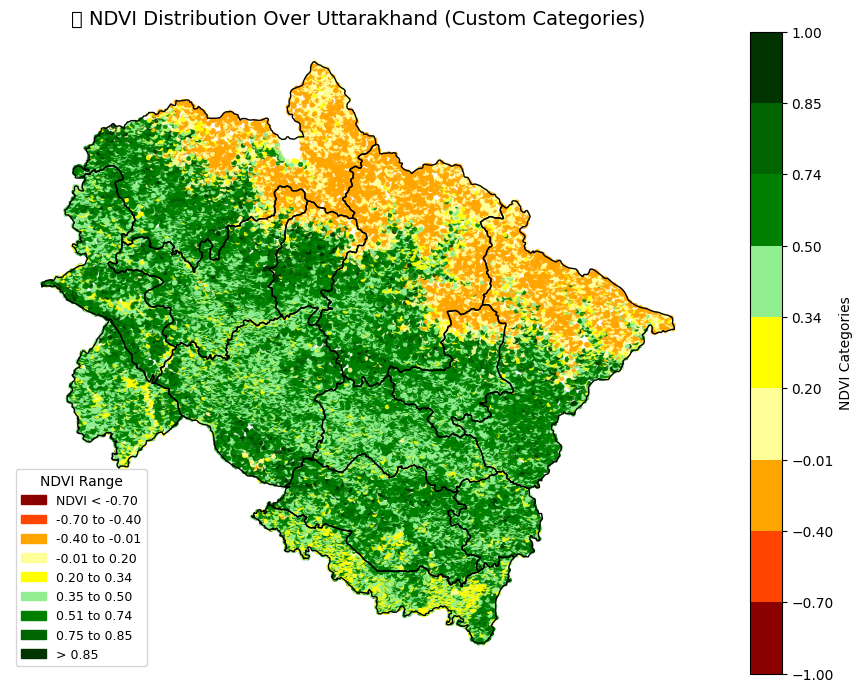

In [18]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Load NDVI data
ndvi_df = pd.read_csv(r"C:\Users\suyas\Hackorbit\fire_cleaned.csv")
geometry = [Point(xy) for xy in zip(ndvi_df['lon'], ndvi_df['lat'])]
ndvi_gdf = gpd.GeoDataFrame(ndvi_df, geometry=geometry, crs="EPSG:4326")

# Load Uttarakhand shapefile
india_districts = gpd.read_file("datameet_maps/maps-master/Districts/Census_2011/2011_Dist.shp")
uttarakhand = india_districts[india_districts['ST_NM'].str.lower() == 'uttarakhand']

# Clip NDVI points to Uttarakhand
ndvi_gdf_clipped = gpd.clip(ndvi_gdf, uttarakhand)

# Define custom NDVI bins and colors
bins = [-1.0, -0.70, -0.40, -0.01, 0.20, 0.34, 0.50, 0.74, 0.85, 1.0]
colors = [
    '#8B0000',  # dark reddish (burnt)
    '#FF4500',  # reddish orange
    '#FFA500',  # orange
    '#FFFF99',  # lime yellow
    '#FFFF00',  # yellow
    '#90EE90',  # light green
    '#008000',  # green
    '#006400',  # dark green
    '#003300'   # super dark green (very rare, just in case)
]

# Create colormap and normalizer
cmap = ListedColormap(colors)
norm = BoundaryNorm(bins, cmap.N)

# Plot map
fig, ax = plt.subplots(figsize=(9, 11))
uttarakhand.boundary.plot(ax=ax, color='black', linewidth=1)

sc = ndvi_gdf_clipped.plot(
    ax=ax,
    column='ndvi',
    cmap=cmap,
    norm=norm,
    markersize=6,
    alpha=0.8,
    legend=True,
    legend_kwds={
        'label': "NDVI Categories",
        'shrink': 0.6,
        'orientation': "vertical"
    }
)

# Custom legend manually (since matplotlib doesn't auto-label discrete bins well)
from matplotlib.patches import Patch
legend_labels = [
    Patch(color='#8B0000', label='NDVI < -0.70'),
    Patch(color='#FF4500', label='-0.70 to -0.40'),
    Patch(color='#FFA500', label='-0.40 to -0.01'),
    Patch(color='#FFFF99', label='-0.01 to 0.20'),
    Patch(color='#FFFF00', label='0.20 to 0.34'),
    Patch(color='#90EE90', label='0.35 to 0.50'),
    Patch(color='#008000', label='0.51 to 0.74'),
    Patch(color='#006400', label='0.75 to 0.85'),
    Patch(color='#003300', label='> 0.85')
]
plt.legend(handles=legend_labels, title="NDVI Range", loc='lower left', fontsize=9, title_fontsize=10)

plt.title("🌿 NDVI Distribution Over Uttarakhand (Custom Categories)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd
import ee
from datetime import datetime
from tqdm import tqdm
import os

# Initialize Earth Engine
ee.Initialize(project='fire-risk-uttarakhand')

# Paths
INPUT_CSV = r"C:\Users\suyas\Hackorbit\fire_cleaned.csv"
OUTPUT_CSV = "enriched_fire_data_with_lst.csv"
CHUNK_SIZE = 500

def enrich_features_with_lst(chunk_df):
    features = []

    for _, row in chunk_df.iterrows():
        try:
            date_str = str(row['date']).replace("fire_", "")
            date_obj = datetime.strptime(date_str, "%Y-%m-%d")
        except Exception as e:
            print(f"❌ Skipping row with invalid date: {row['date']} - {e}")
            continue

        feature = ee.Feature(
            ee.Geometry.Point([row['lon'], row['lat']]),
            {
                'date': date_str,
                'lat': row['lat'],
                'lon': row['lon'],
            }
        )
        features.append(feature)

    fc = ee.FeatureCollection(features)

    def add_lst(feature):
        date = ee.Date(feature.get('date'))
        geom = feature.geometry()

        lst_img = ee.ImageCollection("MODIS/061/MOD11A1") \
            .filterDate(date.advance(-3, 'day'), date.advance(3, 'day')) \
            .filterBounds(geom) \
            .mean() \
            .select("LST_Day_1km") \
            .multiply(0.02) \
            .subtract(273.15)  # Convert from Kelvin to Celsius

        lst_val = lst_img.reduceRegion(ee.Reducer.mean(), geom, 1000).get("LST_Day_1km")

        return feature.set('lst', ee.Algorithms.If(lst_val, lst_val, None))

    enriched_fc = fc.map(add_lst)

    enriched_dicts = enriched_fc.getInfo()['features']
    lst_data = pd.DataFrame([
        {
            'lat': f['properties']['lat'],
            'lon': f['properties']['lon'],
            'date': f['properties']['date'],
            'lst': f['properties'].get('lst')
        }
        for f in enriched_dicts
    ])

    # Clean up column formats
    chunk_df['date'] = chunk_df['date'].astype(str).str.replace("fire_", "")
    lst_data['date'] = lst_data['date'].astype(str)

    # Merge lst into original chunk
    enriched_chunk = chunk_df.merge(lst_data, on=['lat', 'lon', 'date'], how='left')

    return enriched_chunk

# Load input dataset
df = pd.read_csv(INPUT_CSV)

# Process in chunks
total_chunks = (len(df) + CHUNK_SIZE - 1) // CHUNK_SIZE

for i in range(total_chunks):
    start = i * CHUNK_SIZE
    end = min((i + 1) * CHUNK_SIZE, len(df))
    chunk_df = df.iloc[start:end].copy()

    if os.path.exists(OUTPUT_CSV):
        existing = pd.read_csv(OUTPUT_CSV)
        if len(existing) >= end:
            print(f"✅ Skipping chunk {i+1}")
            continue

    print(f"\n⚙️ Processing chunk {i+1}/{total_chunks} [{start}:{end}]")

    try:
        enriched_chunk = enrich_features_with_lst(chunk_df)
        mode = 'a' if os.path.exists(OUTPUT_CSV) else 'w'
        header = not os.path.exists(OUTPUT_CSV)
        enriched_chunk.to_csv(OUTPUT_CSV, mode=mode, header=header, index=False)
        print(f"✅ Saved chunk {i+1}")
    except Exception as e:
        print(f"❌ Error on chunk {i+1}: {e}")
        continue

print("\n✅ LST successfully added. Final file saved to:", OUTPUT_CSV)



⚙️ Processing chunk 1/165 [0:500]
✅ Saved chunk 1

⚙️ Processing chunk 2/165 [500:1000]
✅ Saved chunk 2

⚙️ Processing chunk 3/165 [1000:1500]
✅ Saved chunk 3

⚙️ Processing chunk 4/165 [1500:2000]
✅ Saved chunk 4

⚙️ Processing chunk 5/165 [2000:2500]
✅ Saved chunk 5

⚙️ Processing chunk 6/165 [2500:3000]
✅ Saved chunk 6

⚙️ Processing chunk 7/165 [3000:3500]
✅ Saved chunk 7

⚙️ Processing chunk 8/165 [3500:4000]
✅ Saved chunk 8

⚙️ Processing chunk 9/165 [4000:4500]
✅ Saved chunk 9

⚙️ Processing chunk 10/165 [4500:5000]
✅ Saved chunk 10

⚙️ Processing chunk 11/165 [5000:5500]
✅ Saved chunk 11

⚙️ Processing chunk 12/165 [5500:6000]
✅ Saved chunk 12

⚙️ Processing chunk 13/165 [6000:6500]
✅ Saved chunk 13

⚙️ Processing chunk 14/165 [6500:7000]
✅ Saved chunk 14

⚙️ Processing chunk 15/165 [7000:7500]
✅ Saved chunk 15

⚙️ Processing chunk 16/165 [7500:8000]
✅ Saved chunk 16

⚙️ Processing chunk 17/165 [8000:8500]
✅ Saved chunk 17

⚙️ Processing chunk 18/165 [8500:9000]
✅ Saved chunk 

In [5]:
import pandas as pd
import numpy as np

# Load the original dataset
df = pd.read_csv(r"C:\Users\suyas\Hackorbit\enriched_fire_data_with_lst.csv")

# Replace known string-based nulls with actual NaN
df.replace(to_replace=["NaN", "nan", "NULL", "null", "None", ""], value=np.nan, inplace=True)

# Drop any row that now contains a NaN
df_cleaned = df.dropna()

# Show cleanup info
print(f"⚠️ Original shape: {df.shape}")
print(f"✅ Cleaned shape: {df_cleaned.shape} (removed {df.shape[0] - df_cleaned.shape[0]} bad rows)")

# Save cleaned dataset
df_cleaned.to_csv("fire_cleaned.csv", index=False)
print("💾 Fully cleaned CSV saved as 'fire_cleaned.csv'")


⚠️ Original shape: (79204, 7)
✅ Cleaned shape: (77970, 7) (removed 1234 bad rows)
💾 Fully cleaned CSV saved as 'fire_cleaned.csv'


C:\Users\suyas\AppData\Local\Temp\ipykernel_12320\228951844.py:60: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\suyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


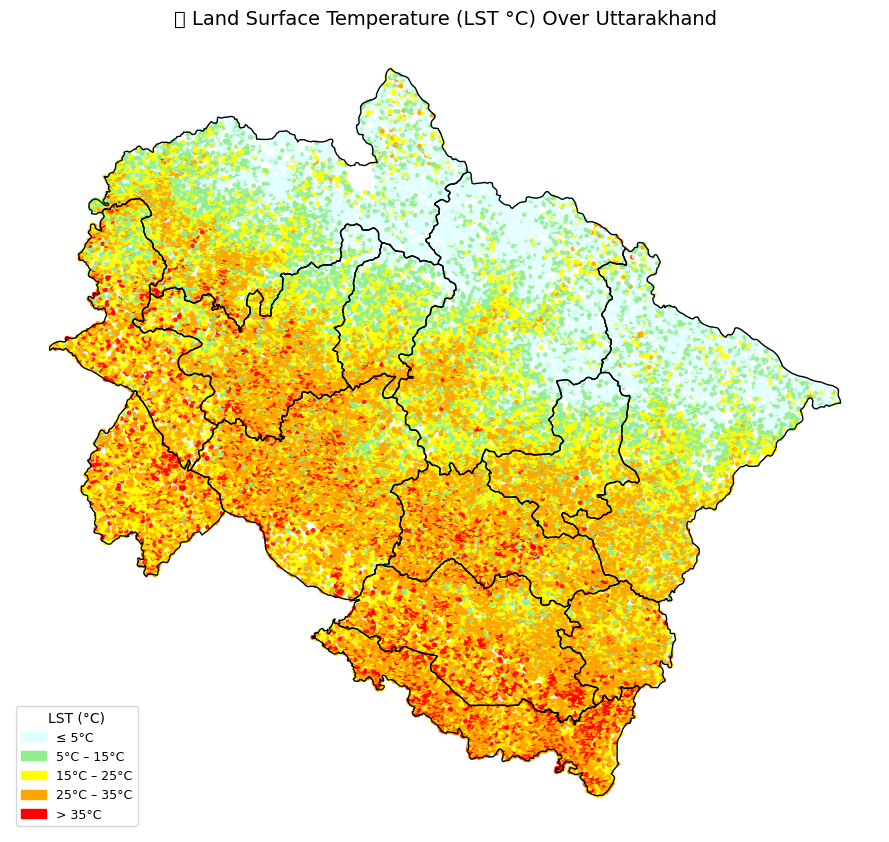

In [8]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

# Load your dataset with LST in Celsius
lst_df = pd.read_csv(r"C:\Users\suyas\Hackorbit\fire_cleaned.csv")

# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(lst_df['lon'], lst_df['lat'])]
lst_gdf = gpd.GeoDataFrame(lst_df, geometry=geometry, crs="EPSG:4326")

# Load Uttarakhand shapefile
india_districts = gpd.read_file("datameet_maps/maps-master/Districts/Census_2011/2011_Dist.shp")
uttarakhand = india_districts[india_districts['ST_NM'].str.lower() == 'uttarakhand']

# Clip to Uttarakhand boundary
lst_gdf_clipped = gpd.clip(lst_gdf, uttarakhand)

# ✅ Custom bins and colors
bins = [-999, 5, 15, 25, 35, 100]  # Extra low/high bounds to include all values
colors = [
    '#E0FFFF',  # Light Cyan (<= 5°C)
    '#90EE90',  # Light Green (>5 - 15°C)
    '#FFFF00',  # Yellow (>15 - 25°C)
    '#FFA500',  # Orange (>25 - 35°C)
    '#FF0000'   # Red (>35°C)
]

cmap = ListedColormap(colors)
norm = BoundaryNorm(bins, cmap.N)

# Plotting
fig, ax = plt.subplots(figsize=(9, 11))
uttarakhand.boundary.plot(ax=ax, color='black', linewidth=1)

lst_gdf_clipped.plot(
    ax=ax,
    column='lst',
    cmap=cmap,
    norm=norm,
    markersize=6,
    alpha=0.8
)

# Custom legend
legend_elements = [
    Patch(color='#E0FFFF', label='≤ 5°C'),
    Patch(color='#90EE90', label='5°C – 15°C'),
    Patch(color='#FFFF00', label='15°C – 25°C'),
    Patch(color='#FFA500', label='25°C – 35°C'),
    Patch(color='#FF0000', label='> 35°C'),
]
plt.legend(handles=legend_elements, title="LST (°C)", loc='lower left', fontsize=9, title_fontsize=10)

plt.title("🌡️ Land Surface Temperature (LST °C) Over Uttarakhand", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


C:\Users\suyas\AppData\Local\Temp\ipykernel_12320\4214977950.py:75: UserWarning: Glyph 127956 (\N{SNOW CAPPED MOUNTAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\suyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127956 (\N{SNOW CAPPED MOUNTAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


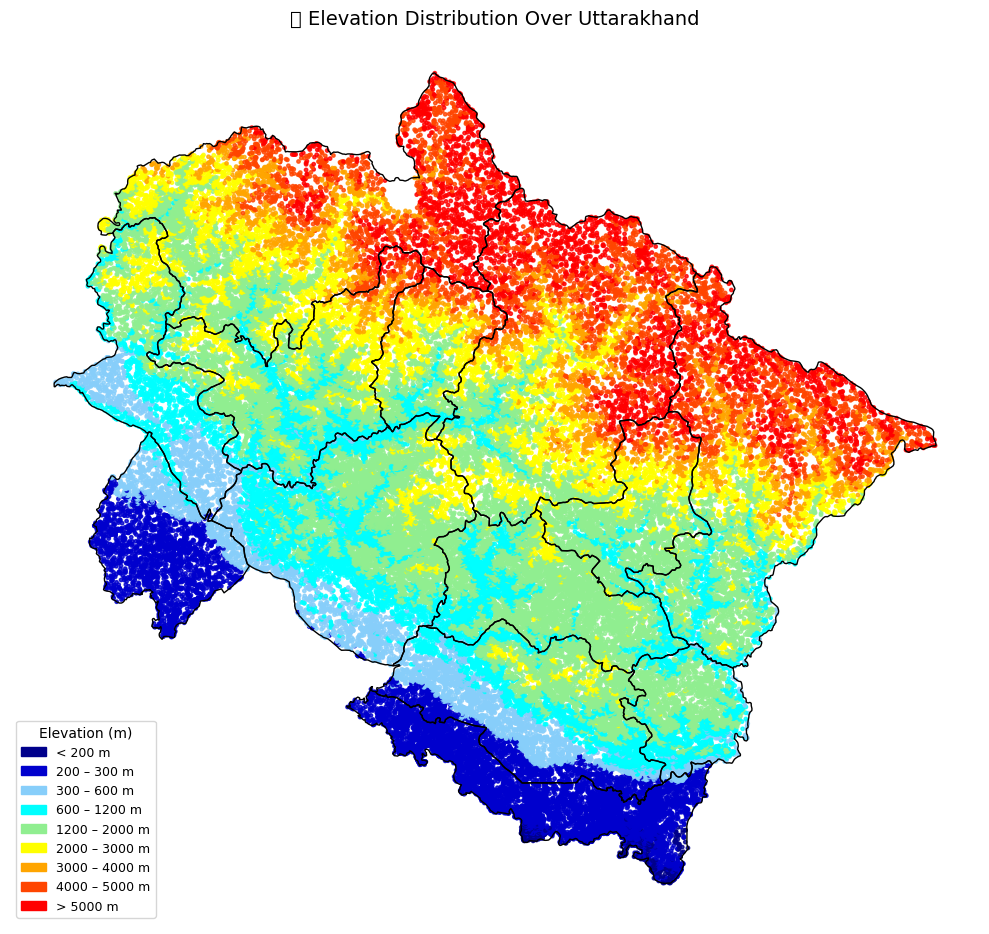

In [13]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

# Load your cleaned CSV with elevation
df = pd.read_csv(r"C:\Users\suyas\Hackorbit\fire_cleaned.csv")

# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Load Uttarakhand boundary
districts = gpd.read_file("datameet_maps/maps-master/Districts/Census_2011/2011_Dist.shp")
uttarakhand = districts[districts['ST_NM'].str.lower() == 'uttarakhand']

# Clip to Uttarakhand
gdf_clipped = gpd.clip(gdf, uttarakhand)

# ✅ Elevation Bins & Colors (as per your scheme)
bins = [-100, 200, 300, 600, 1200, 2000, 3000, 4000, 5000, 9000]
colors = [
    '#00008B',  # Dark Blue
    '#0000CD',  # Medium Blue
    '#87CEFA',  # Light Blue
    '#00FFFF',  # Cyan
    '#90EE90',  # Light Green
    '#FFFF00',  # Yellow
    '#FFA500',  # Orange
    '#FF4500',  # Red-Orange
    '#FF0000'   # Red
]

cmap = ListedColormap(colors)
norm = BoundaryNorm(bins, cmap.N)

# Plot
fig, ax = plt.subplots(figsize=(10, 12))
uttarakhand.boundary.plot(ax=ax, color='black', linewidth=1)

gdf_clipped.plot(
    ax=ax,
    column='elevation',
    cmap=cmap,
    norm=norm,
    markersize=6,
    alpha=0.8
)

# Custom legend
legend_patches = [
    Patch(color='#00008B', label='< 200 m'),
    Patch(color='#0000CD', label='200 – 300 m'),
    Patch(color='#87CEFA', label='300 – 600 m'),
    Patch(color='#00FFFF', label='600 – 1200 m'),
    Patch(color='#90EE90', label='1200 – 2000 m'),
    Patch(color='#FFFF00', label='2000 – 3000 m'),
    Patch(color='#FFA500', label='3000 – 4000 m'),
    Patch(color='#FF4500', label='4000 – 5000 m'),
    Patch(color='#FF0000', label='> 5000 m'),
]

plt.legend(
    handles=legend_patches,
    title="Elevation (m)",
    loc='lower left',
    fontsize=9,
    title_fontsize=10
)

plt.title("🏔️ Elevation Distribution Over Uttarakhand", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


In [29]:
import pandas as pd
import ee
from datetime import datetime
from tqdm import tqdm
import os

# Initialize Earth Engine
ee.Initialize(project='fire-risk-uttarakhand')

# Paths
INPUT_CSV = r"C:\Users\suyas\Hackorbit\fire_cleaned.csv"
OUTPUT_CSV = "fire_data_with_geo_features.csv"
CHUNK_SIZE = 500

def enrich_geo_features(chunk_df):
    # Clean and validate date
    chunk_df['date'] = chunk_df['date'].astype(str).str.replace("fire_", "")
    chunk_df = chunk_df[chunk_df['date'].apply(lambda x: _is_valid_date(x))].copy()

    features = []
    for _, row in chunk_df.iterrows():
        features.append(ee.Feature(
            ee.Geometry.Point([row['lon'], row['lat']]),
            {'lat': row['lat'], 'lon': row['lon'], 'date': row['date']}
        ))

    fc = ee.FeatureCollection(features)

    def add_features(f):
        geom = f.geometry()
        date = ee.Date(f.get("date"))
        year = date.get("year")

        # Clamp year to MODIS range (2001-2020)
        year_num = ee.Number(year)
        clamped_year = year_num.min(2020).max(2001)

        # DEM terrain
        dem = ee.Image("USGS/SRTMGL1_003")
        terrain = ee.Terrain.products(dem)
        slope = terrain.select("slope")
        aspect = terrain.select("aspect")

        # MODIS Land Cover (safe fallback)
        lc_collection = ee.ImageCollection("MODIS/006/MCD12Q1") \
            .filter(ee.Filter.calendarRange(clamped_year, clamped_year, 'year'))

        lc_image = ee.Image(ee.Algorithms.If(
            lc_collection.size().gt(0),
            lc_collection.first().select("LC_Type1"),
            ee.Image.constant(-9999).rename("LC_Type1").toByte()
        ))

        # Reduce
        slope_val = slope.reduceRegion(ee.Reducer.mean(), geom, 90).get("slope")
        aspect_val = aspect.reduceRegion(ee.Reducer.mean(), geom, 90).get("aspect")
        lc_val = lc_image.reduceRegion(ee.Reducer.first(), geom, 500).get("LC_Type1")

        return f.set({
            'slope': ee.Algorithms.If(slope_val, slope_val, None),
            'aspect': ee.Algorithms.If(aspect_val, aspect_val, None),
            'land_cover_type': ee.Algorithms.If(lc_val, lc_val, None)
        })

    enriched_fc = fc.map(add_features)

    enriched_dicts = enriched_fc.getInfo()['features']
    enriched_data = pd.DataFrame([{
        'lat': f['properties']['lat'],
        'lon': f['properties']['lon'],
        'date': f['properties']['date'],
        'slope': f['properties'].get('slope'),
        'aspect': f['properties'].get('aspect'),
        'land_cover_type': f['properties'].get('land_cover_type')
    } for f in enriched_dicts])

    # Replace dummy values with NaN
    enriched_data.replace(-9999, pd.NA, inplace=True)

    return chunk_df.merge(enriched_data, on=['lat', 'lon', 'date'], how='left')

def _is_valid_date(s):
    try:
        datetime.strptime(s, "%Y-%m-%d")
        return True
    except:
        return False

# Load and chunk the data
df = pd.read_csv(INPUT_CSV)
total_chunks = (len(df) + CHUNK_SIZE - 1) // CHUNK_SIZE

for i in range(total_chunks):
    start = i * CHUNK_SIZE
    end = min((i + 1) * CHUNK_SIZE, len(df))
    chunk_df = df.iloc[start:end].copy()

    if os.path.exists(OUTPUT_CSV):
        existing = pd.read_csv(OUTPUT_CSV)
        if len(existing) >= end:
            print(f"✅ Skipping chunk {i+1}")
            continue

    print(f"\n🚀 Processing chunk {i+1}/{total_chunks} [{start}:{end}]")
    try:
        enriched_chunk = enrich_geo_features(chunk_df)
        mode = 'a' if os.path.exists(OUTPUT_CSV) else 'w'
        header = not os.path.exists(OUTPUT_CSV)
        enriched_chunk.to_csv(OUTPUT_CSV, mode=mode, header=header, index=False)
        print(f"✅ Saved chunk {i+1}")
    except Exception as e:
        print(f"❌ Error in chunk {i+1}: {e}")
        continue

print("\n✅ Done! Features added: slope, aspect, land_cover_type.")



🚀 Processing chunk 1/156 [0:500]
✅ Saved chunk 1

🚀 Processing chunk 2/156 [500:1000]
✅ Saved chunk 2

🚀 Processing chunk 3/156 [1000:1500]
✅ Saved chunk 3

🚀 Processing chunk 4/156 [1500:2000]
✅ Saved chunk 4

🚀 Processing chunk 5/156 [2000:2500]
✅ Saved chunk 5

🚀 Processing chunk 6/156 [2500:3000]
✅ Saved chunk 6

🚀 Processing chunk 7/156 [3000:3500]
✅ Saved chunk 7

🚀 Processing chunk 8/156 [3500:4000]
✅ Saved chunk 8

🚀 Processing chunk 9/156 [4000:4500]
✅ Saved chunk 9

🚀 Processing chunk 10/156 [4500:5000]
✅ Saved chunk 10

🚀 Processing chunk 11/156 [5000:5500]
✅ Saved chunk 11

🚀 Processing chunk 12/156 [5500:6000]
✅ Saved chunk 12

🚀 Processing chunk 13/156 [6000:6500]
✅ Saved chunk 13

🚀 Processing chunk 14/156 [6500:7000]
✅ Saved chunk 14

🚀 Processing chunk 15/156 [7000:7500]
✅ Saved chunk 15

🚀 Processing chunk 16/156 [7500:8000]
✅ Saved chunk 16

🚀 Processing chunk 17/156 [8000:8500]
✅ Saved chunk 17

🚀 Processing chunk 18/156 [8500:9000]
✅ Saved chunk 18

🚀 Processing c

In [30]:
import pandas as pd
import numpy as np

# Load the original dataset
df = pd.read_csv(r"C:\Users\suyas\Hackorbit\fire_data_with_geo_features.csv")

# Replace known string-based nulls with actual NaN
df.replace(to_replace=["NaN", "nan", "NULL", "null", "None", ""], value=np.nan, inplace=True)

# Drop any row that now contains a NaN
df_cleaned = df.dropna()

# Show cleanup info
print(f"⚠️ Original shape: {df.shape}")
print(f"✅ Cleaned shape: {df_cleaned.shape} (removed {df.shape[0] - df_cleaned.shape[0]} bad rows)")

# Save cleaned dataset
df_cleaned.to_csv("fire_cleaned.csv", index=False)
print("💾 Fully cleaned CSV saved as 'fire_cleaned.csv'")


⚠️ Original shape: (77970, 10)
✅ Cleaned shape: (75872, 10) (removed 2098 bad rows)
💾 Fully cleaned CSV saved as 'fire_cleaned.csv'


c:\Users\suyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\suyas\AppData\Local\Temp\ipykernel_12320\1387022638.py:86: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\suyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


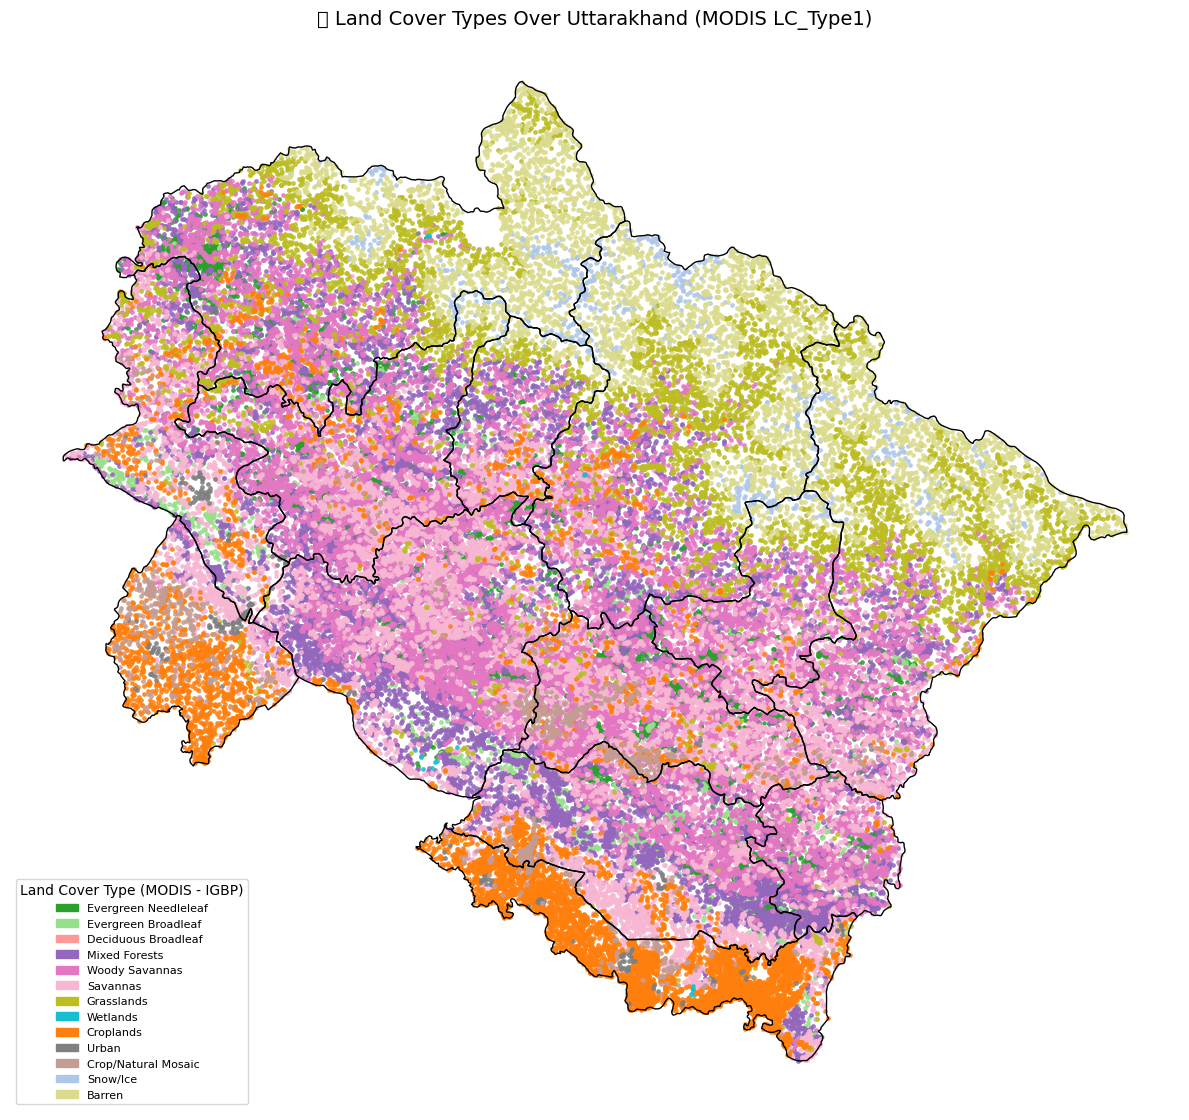

In [31]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load your enriched dataset
df = pd.read_csv(r"C:\Users\suyas\Hackorbit\fire_cleaned.csv")

# Drop rows with missing land_cover_type
df = df.dropna(subset=['land_cover_type'])

# Map numeric MODIS codes to labels (IGBP scheme)
igbp_map = {
    0: "Water", 1: "Evergreen Needleleaf", 2: "Evergreen Broadleaf", 3: "Deciduous Needleleaf",
    4: "Deciduous Broadleaf", 5: "Mixed Forests", 6: "Closed Shrublands", 7: "Open Shrublands",
    8: "Woody Savannas", 9: "Savannas", 10: "Grasslands", 11: "Wetlands", 12: "Croplands",
    13: "Urban", 14: "Crop/Natural Mosaic", 15: "Snow/Ice", 16: "Barren", 254: "Unclassified", 255: "Missing"
}
df['land_cover_label'] = df['land_cover_type'].astype(int).map(igbp_map)

# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Load Uttarakhand boundary shapefile
districts = gpd.read_file("datameet_maps/maps-master/Districts/Census_2011/2011_Dist.shp")
uttarakhand = districts[districts['ST_NM'].str.lower() == 'uttarakhand']

# Clip to Uttarakhand region
gdf_clipped = gpd.clip(gdf, uttarakhand)

# Define color map for major land cover types
land_cover_colors = {
    "Water": "#1f77b4",
    "Evergreen Needleleaf": "#2ca02c",
    "Evergreen Broadleaf": "#98df8a",
    "Deciduous Needleleaf": "#d62728",
    "Deciduous Broadleaf": "#ff9896",
    "Mixed Forests": "#9467bd",
    "Closed Shrublands": "#c5b0d5",
    "Open Shrublands": "#8c564b",
    "Woody Savannas": "#e377c2",
    "Savannas": "#f7b6d2",
    "Grasslands": "#bcbd22",
    "Wetlands": "#17becf",
    "Croplands": "#ff7f0e",
    "Urban": "#7f7f7f",
    "Crop/Natural Mosaic": "#c49c94",
    "Snow/Ice": "#aec7e8",
    "Barren": "#dbdb8d",
    "Unclassified": "#cccccc",
    "Missing": "#ffffff"
}

# Assign colors
gdf_clipped['color'] = gdf_clipped['land_cover_label'].map(land_cover_colors)

# Plot
fig, ax = plt.subplots(figsize=(12, 14))
uttarakhand.boundary.plot(ax=ax, color='black', linewidth=1)

# Plot land cover types with color coding
for label, color in land_cover_colors.items():
    subset = gdf_clipped[gdf_clipped['land_cover_label'] == label]
    if not subset.empty:
        subset.plot(ax=ax, color=color, markersize=6, label=label, alpha=0.8)

# Custom legend
legend_patches = [
    Patch(color=color, label=label)
    for label, color in land_cover_colors.items()
    if label in gdf_clipped['land_cover_label'].values
]

plt.legend(
    handles=legend_patches,
    title="Land Cover Type (MODIS - IGBP)",
    loc='lower left',
    fontsize=8,
    title_fontsize=10
)

plt.title("🌍 Land Cover Types Over Uttarakhand (MODIS LC_Type1)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


C:\Users\suyas\AppData\Local\Temp\ipykernel_12320\280341121.py:35: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\suyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


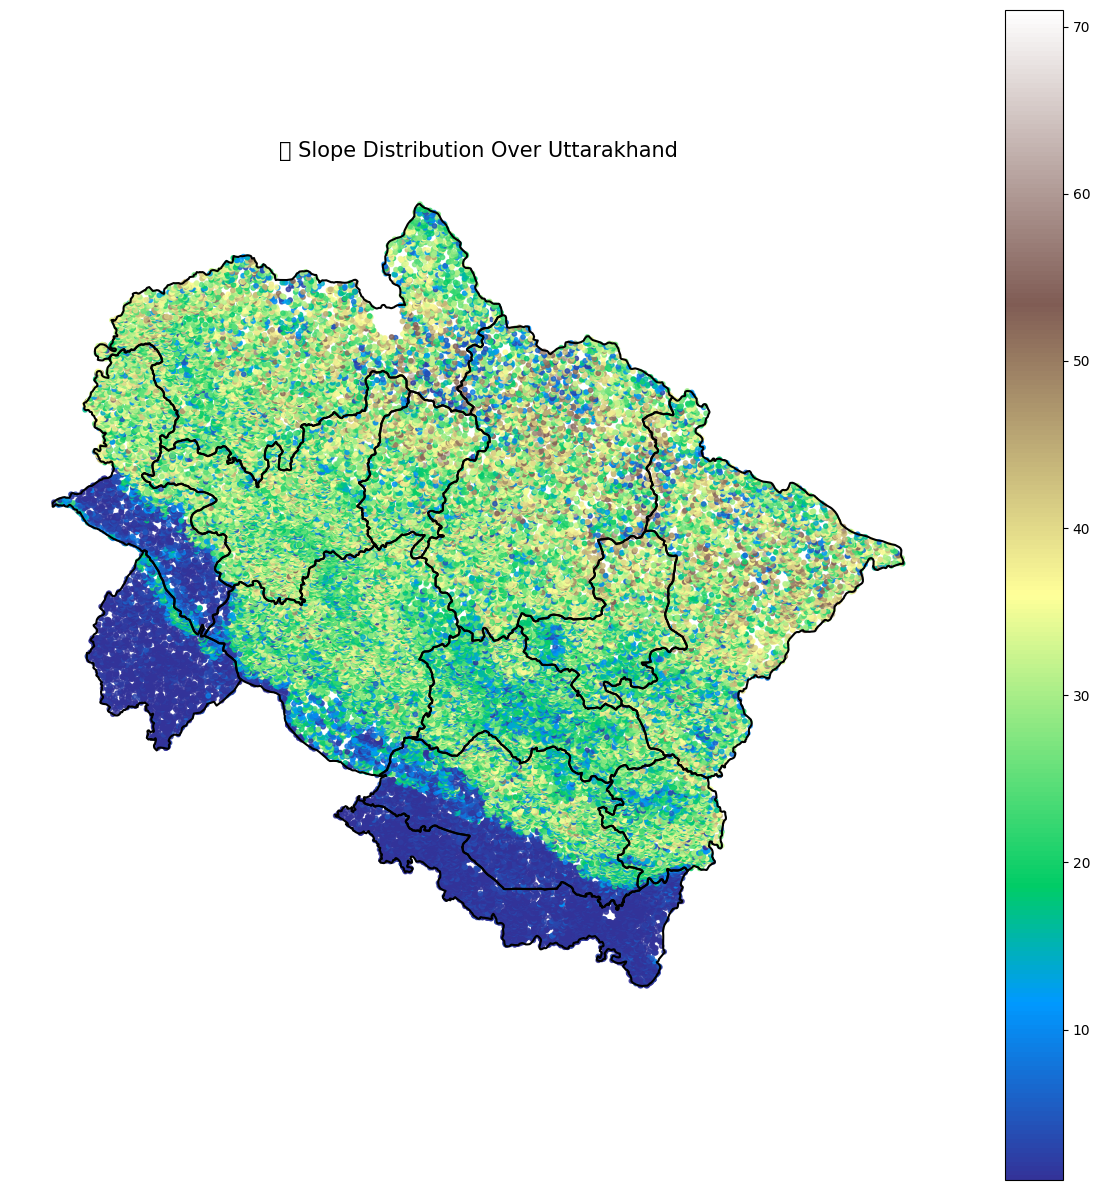

In [33]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from shapely.geometry import Point

# Load fire data
df = pd.read_csv(r"C:\Users\suyas\Hackorbit\fire_cleaned.csv")
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

# Load Uttarakhand shapefile
districts = gpd.read_file("datameet_maps/maps-master/Districts/Census_2011/2011_Dist.shp")
uttarakhand = districts[districts['ST_NM'].str.lower() == 'uttarakhand']

# Clip to Uttarakhand
gdf_clipped = gpd.clip(gdf, uttarakhand)

# Plot Slope over Map
fig, ax = plt.subplots(figsize=(12, 12))
uttarakhand.boundary.plot(ax=ax, color='black')

# Slope-based colormap
gdf_clipped.plot(
    ax=ax,
    column='slope',
    cmap='terrain',
    markersize=10,
    legend=True,
    alpha=0.8
)

plt.title("🗺️ Slope Distribution Over Uttarakhand", fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
import ee
from datetime import datetime
from tqdm import tqdm
import os

# Initialize Earth Engine
ee.Initialize(project='fire-risk-uttarakhand')

# Paths
INPUT_CSV = r"C:\Users\suyas\Hackorbit\fire_cleaned.csv"
OUTPUT_CSV = "enriched_fire_data_with_humidity_only.csv"
CHUNK_SIZE = 250

def enrich_with_humidity_only(chunk_df):
    features = []

    for _, row in chunk_df.iterrows():
        try:
            date_str = str(row['date']).replace("fire_", "")
            date_obj = datetime.strptime(date_str, "%Y-%m-%d")
        except Exception as e:
            print(f"❌ Skipping row with invalid date: {row['date']} - {e}")
            continue

        feature = ee.Feature(
            ee.Geometry.Point([row['lon'], row['lat']]),
            {
                'date': date_str,
                'lat': row['lat'],
                'lon': row['lon'],
            }
        )
        features.append(feature)

    fc = ee.FeatureCollection(features)

    def add_features(f):
        geom = f.geometry()
        date = ee.Date(f.get('date'))

        # ---------- Relative Humidity from ERA5 ----------
        era5 = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY") \
            .filterDate(date.advance(-1, 'day'), date.advance(1, 'day')) \
            .filterBounds(geom) \
            .select(['temperature_2m', 'dewpoint_temperature_2m']) \
            .mean()

        temp = era5.select('temperature_2m')
        dew = era5.select('dewpoint_temperature_2m')

        numerator = dew.multiply(17.625).divide(dew.add(243.04)).exp()
        denominator = temp.multiply(17.625).divide(temp.add(243.04)).exp()
        rh = numerator.divide(denominator).multiply(100).rename("relative_humidity")

        rh_val = rh.reduceRegion(ee.Reducer.mean(), geom, 1000).get('relative_humidity')

        return f.set({
            'relative_humidity': ee.Algorithms.If(rh_val, rh_val, None)
        })

    enriched_fc = fc.map(add_features)

    enriched_dicts = enriched_fc.getInfo()['features']
    enriched_data = pd.DataFrame([{
        'lat': f['properties']['lat'],
        'lon': f['properties']['lon'],
        'date': f['properties']['date'],
        'relative_humidity': f['properties'].get('relative_humidity')
    } for f in enriched_dicts])

    chunk_df['date'] = chunk_df['date'].astype(str).str.replace("fire_", "")
    enriched_data['date'] = enriched_data['date'].astype(str)

    enriched_chunk = chunk_df.merge(enriched_data, on=['lat', 'lon', 'date'], how='left')

    return enriched_chunk

# Load data
df = pd.read_csv(INPUT_CSV)
total_chunks = (len(df) + CHUNK_SIZE - 1) // CHUNK_SIZE

for i in range(total_chunks):
    start = i * CHUNK_SIZE
    end = min((i + 1) * CHUNK_SIZE, len(df))
    chunk_df = df.iloc[start:end].copy()

    if os.path.exists(OUTPUT_CSV):
        existing = pd.read_csv(OUTPUT_CSV)
        if len(existing) >= end:
            print(f"✅ Skipping chunk {i+1}")
            continue

    print(f"\n🔄 Processing chunk {i+1}/{total_chunks} [{start}:{end}]")
    try:
        enriched_chunk = enrich_with_humidity_only(chunk_df)
        mode = 'a' if os.path.exists(OUTPUT_CSV) else 'w'
        header = not os.path.exists(OUTPUT_CSV)
        enriched_chunk.to_csv(OUTPUT_CSV, mode=mode, header=header, index=False)
        print(f"✅ Saved chunk {i+1}")
    except Exception as e:
        print(f"❌ Error on chunk {i+1}: {e}")
        continue

print("\n✅ Relative Humidity added! Final file:", OUTPUT_CSV)



🔄 Processing chunk 1/304 [0:250]
✅ Saved chunk 1

🔄 Processing chunk 2/304 [250:500]
✅ Saved chunk 2

🔄 Processing chunk 3/304 [500:750]
✅ Saved chunk 3

🔄 Processing chunk 4/304 [750:1000]
✅ Saved chunk 4

🔄 Processing chunk 5/304 [1000:1250]
✅ Saved chunk 5

🔄 Processing chunk 6/304 [1250:1500]
✅ Saved chunk 6

🔄 Processing chunk 7/304 [1500:1750]
✅ Saved chunk 7

🔄 Processing chunk 8/304 [1750:2000]
✅ Saved chunk 8

🔄 Processing chunk 9/304 [2000:2250]
✅ Saved chunk 9

🔄 Processing chunk 10/304 [2250:2500]
✅ Saved chunk 10

🔄 Processing chunk 11/304 [2500:2750]
✅ Saved chunk 11

🔄 Processing chunk 12/304 [2750:3000]
✅ Saved chunk 12

🔄 Processing chunk 13/304 [3000:3250]
✅ Saved chunk 13

🔄 Processing chunk 14/304 [3250:3500]
✅ Saved chunk 14

🔄 Processing chunk 15/304 [3500:3750]
✅ Saved chunk 15

🔄 Processing chunk 16/304 [3750:4000]
✅ Saved chunk 16

🔄 Processing chunk 17/304 [4000:4250]
✅ Saved chunk 17

🔄 Processing chunk 18/304 [4250:4500]
✅ Saved chunk 18

🔄 Processing chunk

In [10]:
import pandas as pd
import ee
from datetime import datetime
from tqdm import tqdm
import os

# Initialize Earth Engine
ee.Initialize(project='fire-risk-uttarakhand')

# Paths
INPUT_CSV = r"C:\Users\suyas\Hackorbit\enriched_fire_data_with_humidity_only.csv"
OUTPUT_CSV = "enriched_fire_data_with_wind_only.csv"
CHUNK_SIZE = 250

def enrich_with_wind_only(chunk_df):
    features = []

    for _, row in chunk_df.iterrows():
        try:
            date_str = str(row['date']).replace("fire_", "")
            date_obj = datetime.strptime(date_str, "%Y-%m-%d")
        except Exception as e:
            print(f"❌ Skipping row with invalid date: {row['date']} - {e}")
            continue

        feature = ee.Feature(
            ee.Geometry.Point([row['lon'], row['lat']]),
            {
                'date': date_str,
                'lat': row['lat'],
                'lon': row['lon'],
            }
        )
        features.append(feature)

    fc = ee.FeatureCollection(features)

    def add_features(f):
        geom = f.geometry()
        date = ee.Date(f.get('date'))

        # ---------- ERA5 Wind (u10, v10) ----------
        era5 = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY") \
            .filterDate(date.advance(-1, 'day'), date.advance(1, 'day')) \
            .filterBounds(geom) \
            .select(['u_component_of_wind_10m', 'v_component_of_wind_10m']) \
            .mean()

        u10 = era5.select('u_component_of_wind_10m')
        v10 = era5.select('v_component_of_wind_10m')

        wind_speed = u10.pow(2).add(v10.pow(2)).sqrt().rename("wind_speed")

        wind_val = wind_speed.reduceRegion(ee.Reducer.mean(), geom, 1000).get('wind_speed')

        return f.set({
            'wind_speed': ee.Algorithms.If(wind_val, wind_val, None)
        })

    enriched_fc = fc.map(add_features)

    enriched_dicts = enriched_fc.getInfo()['features']
    enriched_data = pd.DataFrame([{
        'lat': f['properties']['lat'],
        'lon': f['properties']['lon'],
        'date': f['properties']['date'],
        'wind_speed': f['properties'].get('wind_speed')
    } for f in enriched_dicts])

    chunk_df['date'] = chunk_df['date'].astype(str).str.replace("fire_", "")
    enriched_data['date'] = enriched_data['date'].astype(str)

    enriched_chunk = chunk_df.merge(enriched_data, on=['lat', 'lon', 'date'], how='left')

    return enriched_chunk

# Load data
df = pd.read_csv(INPUT_CSV)
total_chunks = (len(df) + CHUNK_SIZE - 1) // CHUNK_SIZE

for i in range(total_chunks):
    start = i * CHUNK_SIZE
    end = min((i + 1) * CHUNK_SIZE, len(df))
    chunk_df = df.iloc[start:end].copy()

    if os.path.exists(OUTPUT_CSV):
        existing = pd.read_csv(OUTPUT_CSV)
        if len(existing) >= end:
            print(f"✅ Skipping chunk {i+1}")
            continue

    print(f"\n🌬️ Processing chunk {i+1}/{total_chunks} [{start}:{end}]")
    try:
        enriched_chunk = enrich_with_wind_only(chunk_df)
        mode = 'a' if os.path.exists(OUTPUT_CSV) else 'w'
        header = not os.path.exists(OUTPUT_CSV)
        enriched_chunk.to_csv(OUTPUT_CSV, mode=mode, header=header, index=False)
        print(f"✅ Saved chunk {i+1}")
    except Exception as e:
        print(f"❌ Error on chunk {i+1}: {e}")
        continue

print("\n✅ Wind speed added! Final file:", OUTPUT_CSV)



🌬️ Processing chunk 1/304 [0:250]
✅ Saved chunk 1

🌬️ Processing chunk 2/304 [250:500]
✅ Saved chunk 2

🌬️ Processing chunk 3/304 [500:750]
✅ Saved chunk 3

🌬️ Processing chunk 4/304 [750:1000]
✅ Saved chunk 4

🌬️ Processing chunk 5/304 [1000:1250]
✅ Saved chunk 5

🌬️ Processing chunk 6/304 [1250:1500]
✅ Saved chunk 6

🌬️ Processing chunk 7/304 [1500:1750]
✅ Saved chunk 7

🌬️ Processing chunk 8/304 [1750:2000]
✅ Saved chunk 8

🌬️ Processing chunk 9/304 [2000:2250]
✅ Saved chunk 9

🌬️ Processing chunk 10/304 [2250:2500]
✅ Saved chunk 10

🌬️ Processing chunk 11/304 [2500:2750]
✅ Saved chunk 11

🌬️ Processing chunk 12/304 [2750:3000]
✅ Saved chunk 12

🌬️ Processing chunk 13/304 [3000:3250]
✅ Saved chunk 13

🌬️ Processing chunk 14/304 [3250:3500]
✅ Saved chunk 14

🌬️ Processing chunk 15/304 [3500:3750]
✅ Saved chunk 15

🌬️ Processing chunk 16/304 [3750:4000]
✅ Saved chunk 16

🌬️ Processing chunk 17/304 [4000:4250]
✅ Saved chunk 17

🌬️ Processing chunk 18/304 [4250:4500]
✅ Saved chunk 18



In [11]:
import pandas as pd
import numpy as np

# Load the original dataset
df = pd.read_csv(r"C:\Users\suyas\Hackorbit\enriched_fire_data_with_wind_only.csv")

# Create a copy to detect "bad" values
df_check = df.copy()

# Replace known string-based nulls with actual NaN for detection only
df_check.replace(to_replace=["NaN", "nan", "NULL", "null", "None", ""], value=np.nan, inplace=True)

# Count how many rows contain at least one NaN after replacement
num_bad_rows = df_check.isna().any(axis=1).sum()

# Output summary
print(f"📊 Total rows in dataset: {df.shape[0]}")
print(f"⚠️ Rows containing any null/missing value: {num_bad_rows}")
print(f"✅ Clean rows (fully filled): {df.shape[0] - num_bad_rows}")


📊 Total rows in dataset: 75872
⚠️ Rows containing any null/missing value: 0
✅ Clean rows (fully filled): 75872


In [4]:
import pandas as pd
import numpy as np

# Load the original dataset
df = pd.read_csv(r"C:\Users\suyas\Hackorbit\enriched_fire_data_with_precip.csv")

# Create a copy to detect "bad" values
df_check = df.copy()

# Replace known string-based nulls with actual NaN for detection only
df_check.replace(to_replace=["NaN", "nan", "NULL", "null", "None", ""], value=np.nan, inplace=True)

# Count how many rows contain at least one NaN after replacement
num_bad_rows = df_check.isna().any(axis=1).sum()

# Output summary
print(f"📊 Total rows in dataset: {df.shape[0]}")
print(f"⚠️ Rows containing any null/missing value: {num_bad_rows}")
print(f"✅ Clean rows (fully filled): {df.shape[0] - num_bad_rows}")


📊 Total rows in dataset: 75872
⚠️ Rows containing any null/missing value: 21176
✅ Clean rows (fully filled): 54696


In [41]:
import pandas as pd

# Load your CSV
df = pd.read_csv(r"C:\Users\suyas\Hackorbit\fire_cleaned.csv")

# Convert 'date' to datetime and extract month
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month

# Save updated DataFrame back to CSV with the new 'month' column
df.to_csv(r"C:\Users\suyas\Hackorbit\fire_cleaned.csv", index=False)

# Optional: print a few rows to confirm
print(df[['date', 'month']].head())


        date  month
0 2019-01-01      1
1 2019-01-01      1
2 2019-01-01      1
3 2019-01-01      1
4 2019-01-01      1


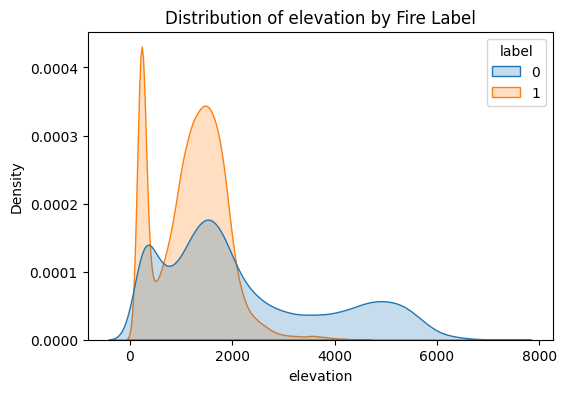

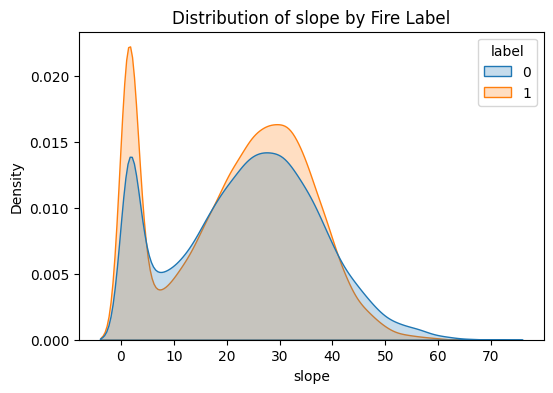

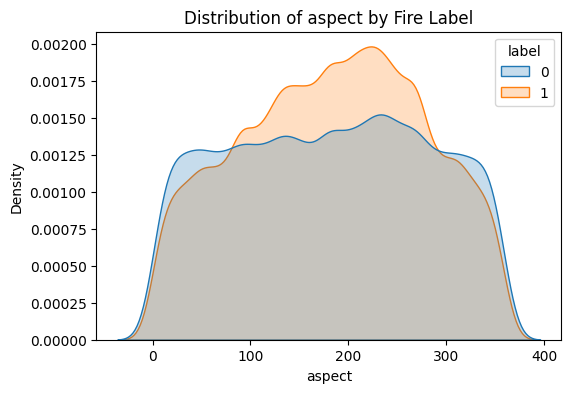

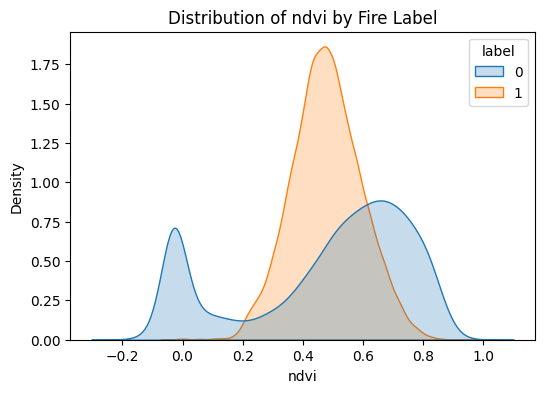

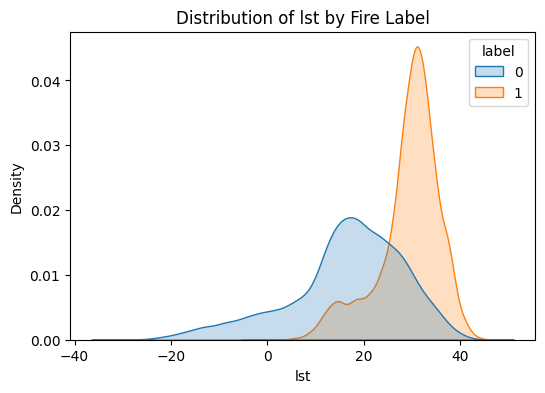

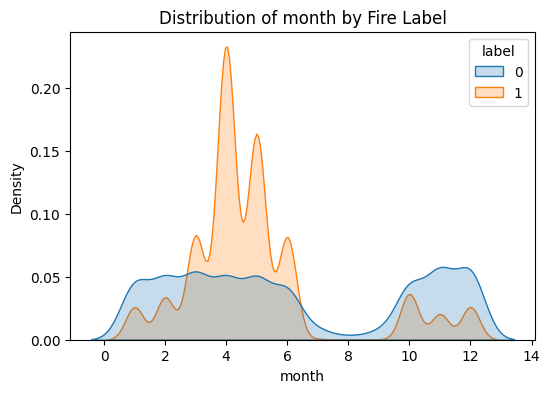

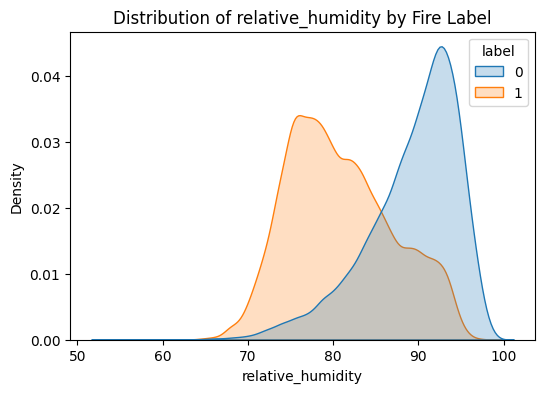

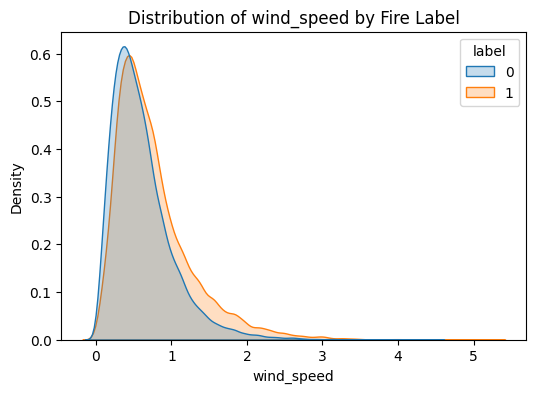

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(r"C:\Users\suyas\Hackorbit\enriched_fire_data_with_wind_only.csv")

cols = ['elevation', 'slope', 'aspect', 'ndvi', 'lst','month','relative_humidity','wind_speed']
for col in cols:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df, x=col, hue='label', fill=True)
    plt.title(f'Distribution of {col} by Fire Label')
    plt.show()


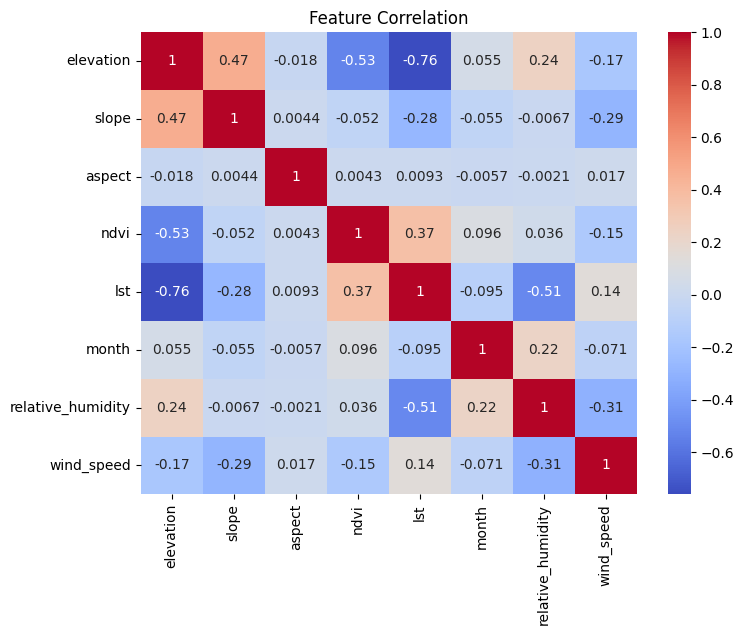

In [14]:
import seaborn as sns
import numpy as np

plt.figure(figsize=(8, 6))
sns.heatmap(df[cols].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load cleaned dataset
df = pd.read_csv(r"C:\Users\suyas\Hackorbit\enriched_fire_data_with_wind_only.csv")

# Drop rows with missing values (just in case)
df = df.dropna()

# Features and label
X = df.drop(columns=['label', 'date','lat', 'lon'])
y = df['label']

# Step 1: 70% Train, 30% Temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Step 2: Split Temp into 15% Val and 15% Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Final split sizes
print(f"✅ Final splits:")
print(f"Train: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")

# Train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Validation Results
val_preds = clf.predict(X_val)
val_acc = accuracy_score(y_val, val_preds)
print("\n📊 Validation Set:")
print(f"Accuracy: {val_acc:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_val, val_preds))
print("Classification Report:\n", classification_report(y_val, val_preds))

# Test Results
test_preds = clf.predict(X_test)
test_acc = accuracy_score(y_test, test_preds)
print("\n🧪 Test Set:")
print(f"Accuracy: {test_acc:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))
print("Classification Report:\n", classification_report(y_test, test_preds))


✅ Final splits:
Train: 53110 samples
Validation: 11381 samples
Test: 11381 samples

📊 Validation Set:
Accuracy: 0.8715
Confusion Matrix:
 [[4595  841]
 [ 621 5324]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.85      0.86      5436
           1       0.86      0.90      0.88      5945

    accuracy                           0.87     11381
   macro avg       0.87      0.87      0.87     11381
weighted avg       0.87      0.87      0.87     11381


🧪 Test Set:
Accuracy: 0.8650
Confusion Matrix:
 [[4607  829]
 [ 707 5238]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      5436
           1       0.86      0.88      0.87      5945

    accuracy                           0.87     11381
   macro avg       0.87      0.86      0.86     11381
weighted avg       0.87      0.87      0.86     11381



C:\Users\suyas\AppData\Local\Temp\ipykernel_43104\1731884962.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
C:\Users\suyas\AppData\Local\Temp\ipykernel_43104\1731884962.py:20: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\suyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


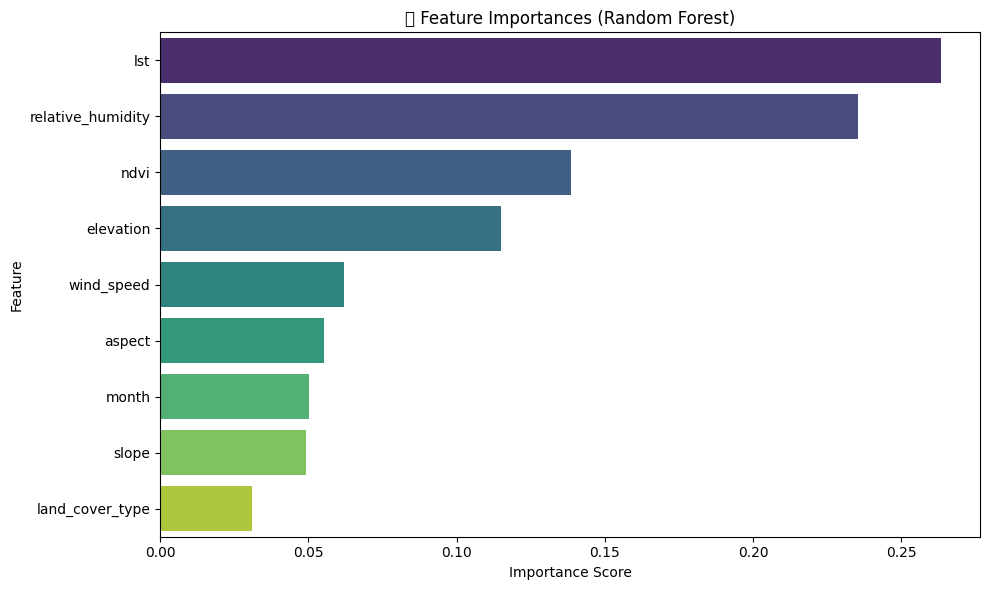

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = clf.feature_importances_
feature_names = X.columns

# Create a DataFrame for better plotting
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('🧠 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [21]:
from collections import Counter
from imblearn.over_sampling import SMOTE

# y should be your labels
print("Class distribution:", Counter(y))

# Optional: Apply SMOTE
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

print("After SMOTE:", Counter(y))


Class distribution: Counter({1: 39631, 0: 36241})
After SMOTE: Counter({1: 39631, 0: 39631})


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingGridSearchCV
from tqdm import tqdm
import numpy as np

# Define your parameter grid (keep this compact for speed, tweak if needed)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Initialize RF
rf = RandomForestClassifier(random_state=42)

# Wrap HalvingGridSearchCV in tqdm by subclassing
class TQDMHalvingGridSearchCV(HalvingGridSearchCV):
    def fit(self, X, y=None, **fit_params):
        with tqdm(total=1, desc="⏳ Searching Best Model (HalvingGridSearchCV)", unit="stage") as pbar:
            result = super().fit(X, y, **fit_params)
            pbar.update()
        return result

# Initialize HalvingGridSearchCV with tqdm progress bar
grid_search = TQDMHalvingGridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    factor=2,                  # halving factor
    resource='n_samples',      # halving resource
    max_resources='auto',
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Run search
grid_search.fit(X, y)

# Best estimator
best_rf = grid_search.best_estimator_

# Print results
print("\n✅ Best Parameters:")
print(grid_search.best_params_)


⏳ Searching Best Model (HalvingGridSearchCV):   0%|          | 0/1 [00:00<?, ?stage/s]

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 2476
max_resources_: 79262
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 48
n_resources: 2476
Fitting 5 folds for each of 48 candidates, totalling 240 fits
----------
iter: 1
n_candidates: 24
n_resources: 4952
Fitting 5 folds for each of 24 candidates, totalling 120 fits
----------
iter: 2
n_candidates: 12
n_resources: 9904
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 3
n_candidates: 6
n_resources: 19808
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 4
n_candidates: 3
n_resources: 39616
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 5
n_candidates: 2
n_resources: 79232
Fitting 5 folds for each of 2 candidates, totalling 10 fits


⏳ Searching Best Model (HalvingGridSearchCV): 100%|██████████| 1/1 [02:30<00:00, 150.91s/stage]


✅ Best Parameters:
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [23]:
from sklearn.ensemble import RandomForestClassifier

# Best found params
best_params = {
    'bootstrap': True,
    'max_depth': 10,
    'min_samples_leaf': 2,
    'min_samples_split': 5,
    'n_estimators': 200,
    'random_state': 42
}

# Retrain model on full balanced data
final_model = RandomForestClassifier(**best_params)
final_model.fit(X, y)


RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test set
y_pred = final_model.predict(X_test)

# Show results
print("🧪 Classification Report:")
print(classification_report(y_test, y_pred))

print("📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


🧪 Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      5436
           1       0.88      0.89      0.88      5945

    accuracy                           0.88     11381
   macro avg       0.88      0.87      0.87     11381
weighted avg       0.88      0.88      0.88     11381

📊 Confusion Matrix:
[[4691  745]
 [ 674 5271]]


In [25]:
import joblib

# Save the best RF model
joblib.dump(best_rf, 'best_random_forest_model2.pkl')
print("✅ Model saved as 'best_random_forest_model.pkl'")


✅ Model saved as 'best_random_forest_model.pkl'


# More Models

c:\Users\suyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:06:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 Validation Set:
Accuracy: 0.8525
Confusion Matrix:
 [[4441  995]
 [ 684 5261]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.84      5436
           1       0.84      0.88      0.86      5945

    accuracy                           0.85     11381
   macro avg       0.85      0.85      0.85     11381
weighted avg       0.85      0.85      0.85     11381


🧪 Test Set:
Accuracy: 0.8555
Confusion Matrix:
 [[4486  950]
 [ 694 5251]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      5436
           1       0.85      0.88      0.86      5945

    accuracy                           0.86     11381
   macro avg       0.86      0.85      0.85     11381
weighted avg       0.86      0.86      0.86     11381



<Figure size 1000x600 with 0 Axes>

c:\Users\suyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


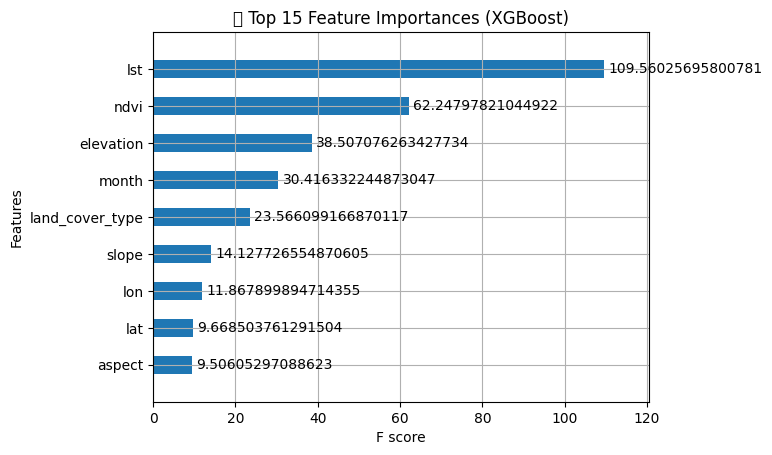

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("fire_cleaned.csv")

# Add 'month' feature
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month

# Drop date column for modeling
df = df.drop(columns=['date'])

# Split features/labels
X = df.drop(columns=['label'])
y = df['label']

# === Train/Val/Test Split (70/15/15) ===
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

# === Train XGBoost Classifier ===
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)

# === Validation Metrics ===
val_preds = xgb_model.predict(X_val)
print("\n📊 Validation Set:")
print(f"Accuracy: {accuracy_score(y_val, val_preds):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_val, val_preds))
print("Classification Report:\n", classification_report(y_val, val_preds))

# === Test Metrics ===
test_preds = xgb_model.predict(X_test)
print("\n🧪 Test Set:")
print(f"Accuracy: {accuracy_score(y_test, test_preds):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))
print("Classification Report:\n", classification_report(y_test, test_preds))

# === Feature Importance Plot ===
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type='gain', height=0.5, max_num_features=15)
plt.title("🔥 Top 15 Feature Importances (XGBoost)")
plt.show()


In [31]:
import joblib
import numpy as np
import pandas as pd

# === STEP 1: Load Trained Model ===
model_path = r"C:\Users\suyas\Hackorbit\best_random_forest_model.pkl"
model = joblib.load(model_path)

# === STEP 2: Sample Inputs (fire-prone tile features) ===
X_tiles = [
    [400, 29.4, 78.0, 0.7, 35, 10, 180, 1, 5, 25, 2],    # 🔥
    [500, 30.1, 78.2, 0.85, 33, 15, 220, 2, 6, 20, 3.5], # 🔥
    [2500, 30.8, 79.0, 0.1, 10, 40, 270, 3, 1, 85, 1.2], # 🌿
    [1100, 29.7, 77.9, 0.3, 20, 5, 90, 4, 12, 60, 1.5],  # 🌿
    [150, 29.2, 78.3, 0.15, 40, 2, 180, 1, 4, 30, 4.2],  # 🔥
    [900, 30.0, 78.1, 0.5, 24, 12, 60, 1, 11, 75, 1.2],  # 🌿
    [1800, 30.5, 79.2, 0.7, 22, 30, 310, 1, 6, 40, 2.5], # 🔥
    [2200, 30.6, 79.3, 0.9, 15, 20, 280, 1, 8, 90, 1.0], # 🌿
    [600, 29.5, 78.5, 0.25, 37, 3, 100, 2, 5, 25, 5.0],  # 🔥
    [1200, 30.3, 78.7, 0.4, 21, 5, 150, 3, 2, 80, 1.0],  # 🌿
    [850, 29.9, 78.0, 0.1, 39, 1, 45, 2, 4, 15, 6.0],    # 🔥
    [2000, 30.7, 79.5, 0.6, 18, 25, 200, 1, 7, 65, 1.5], # 🌿
    [100, 29.3, 78.4, 0.3, 42, 2, 190, 4, 5, 22, 4.5],   # 🔥
    [950, 30.0, 78.2, 0.9, 29, 10, 160, 1, 8, 90, 0.8],  # 🌿
    [1350, 30.2, 78.6, 0.45, 33, 20, 240, 1, 4, 30, 2.2],# 🔥
    [500, 29.5, 78.1, 0.05, 38, 5, 90, 2, 3, 10, 5.5],   # 🔥
    [750, 30.1, 78.4, 0.6, 31, 8, 180, 1, 6, 55, 1.0],   # 🌿
    [3000, 30.9, 79.8, 0.2, 12, 35, 320, 1, 1, 90, 0.5], # 🌿
    [700, 29.8, 78.3, 0.4, 36, 6, 100, 1, 5, 20, 3.8],   # 🔥
    [1250, 30.3, 78.7, 0.8, 28, 10, 150, 1, 9, 85, 1.2], # 🌿
]

columns = [
    "elevation", "lat", "lon", "ndvi", "lst", "slope", "aspect",
    "land_cover_type", "month", "relative_humidity", "wind_speed"
]

X_df = pd.DataFrame(X_tiles, columns=columns)

# === STEP 3: Make Predictions + Probabilities ===
predictions = model.predict(X_df)
probabilities = model.predict_proba(X_df)[:, 1]  # Probability of class 1 = FIRE

# === STEP 4: Display Results ===
print("🔥 Fire Risk Predictions\n------------------------")
for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
    label = "🔥 FIRE" if pred == 1 else "🌿 SAFE"
    print(f"Tile {i+1:02d}: {label} (Prediction: {pred}, Confidence: {prob:.2f})")


🔥 Fire Risk Predictions
------------------------
Tile 01: 🔥 FIRE (Prediction: 1, Confidence: 0.62)
Tile 02: 🔥 FIRE (Prediction: 1, Confidence: 0.55)
Tile 03: 🌿 SAFE (Prediction: 0, Confidence: 0.39)
Tile 04: 🔥 FIRE (Prediction: 1, Confidence: 0.58)
Tile 05: 🔥 FIRE (Prediction: 1, Confidence: 0.78)
Tile 06: 🔥 FIRE (Prediction: 1, Confidence: 0.64)
Tile 07: 🔥 FIRE (Prediction: 1, Confidence: 0.65)
Tile 08: 🌿 SAFE (Prediction: 0, Confidence: 0.03)
Tile 09: 🔥 FIRE (Prediction: 1, Confidence: 0.84)
Tile 10: 🔥 FIRE (Prediction: 1, Confidence: 0.76)
Tile 11: 🔥 FIRE (Prediction: 1, Confidence: 0.76)
Tile 12: 🔥 FIRE (Prediction: 1, Confidence: 0.62)
Tile 13: 🔥 FIRE (Prediction: 1, Confidence: 0.81)
Tile 14: 🌿 SAFE (Prediction: 0, Confidence: 0.07)
Tile 15: 🔥 FIRE (Prediction: 1, Confidence: 0.96)
Tile 16: 🔥 FIRE (Prediction: 1, Confidence: 0.74)
Tile 17: 🔥 FIRE (Prediction: 1, Confidence: 0.86)
Tile 18: 🌿 SAFE (Prediction: 0, Confidence: 0.22)
Tile 19: 🔥 FIRE (Prediction: 1, Confidence: 0.91)
T